[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/royforestano/2023_Anomaly_Detection/blob/main/2023_novelty_and_outlier_detection_exoplanets_taurex.ipynb)

# Searching for Novel Chemistry in Exoplanetary Atmospheres Using Machine Learning for Anomaly Detection

Connected to the paper: https://iopscience.iop.org/article/10.3847/1538-4357/ad0047

## Initialize the Data

In [1]:
from google.colab import files

Definne constants.

In [2]:
RJ = 71492000 # Jupiter radius in meters
MJ = 1.89813*10**(27) # mass of Jupiter in kg

Rearth = 6.378*10**6 # radius of earth in meters
Mearth = 5.972*10**24 # mass of earth in kg

Rsun = 696340000 # Sun radius in meters
Rstar = 2 * Rsun # Host star radius in meters

k = 1.38064852 * 10**(-23) # Boltzmann constant
gamma = 0.57721 # EM constant in case we need it
g_earth = 9.8  # in m/s^2

mamu = 1.66053906660*10**(-27) # atomic mass in kg
mbar = 2.4 * mamu  # mean molecular mass for hot Jupiter
#mbar = 28 * mamu  # mean molecular mass for Earth

mX   = 18  * mamu  # constituent mass (H2O)
X    = 10**(-3)  # mixing ratio
chiX = 10**(-2)  # sigmaX/mX

Temp = 300
Gnewton = 6.67430*10**(-11) # Newton constant

Rplanet = RJ  # planet radius
Mplanet = (Rplanet/RJ)**3*MJ # planet mass using Jupiter density

Rplanet = Rearth
Mplanet = Mearth

Rzero = 1.01 * Rplanet # reference radius
Pzero = 10*10**5 # 10 bars converted in Pa
Nzero = Pzero/(k*Temp)

R_bot = Rplanet
R_top = (1+0.2)*Rplanet

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

In [5]:
import os
path = '/content/drive/MyDrive/your_path'
directory = path
os.chdir(directory)
print(os.getcwd())

/content/drive/MyDrive/UF_Courses/2022_fall/2022_fall_ml/lectures/Lec15_10_20_2022


Read the data in and change to numpy arrays.

In [6]:
obs_data   = pd.read_csv(path+'obs_data.csv').drop('planet_ID', axis=1) # all_data file with 27 features
aux_data   = pd.read_csv(path+'aux_data.csv').drop('Unnamed: 0', axis=1)   # aux data from obs_data that matches the 9 features in the Ariel Data Challenge
FM_data   = pd.read_csv(path+'obs_FM_data.csv').drop('Unnamed: 0', axis=1)   # FM data from obs_data that matches the 6 FM features in the Ariel Data Challenge
taurex_matrix = np.load(path+'taurex_matrix.npy')

obs = obs_data.to_numpy()
aux = aux_data.to_numpy()
FM = FM_data.to_numpy()

print('----------------------------------------------------------------')
print('Taurex Matrix:', taurex_matrix.shape) # samples, 52 wavelengths [0], 52 observations [1]
wavelengths = taurex_matrix[0,:,0]
spectra_ideal = taurex_matrix[:,:,1] # spectra
print('Wavelengths', wavelengths.shape)
print('Spectra shape: ',spectra_ideal.shape)
print('----------------------------------------------------------------')
print('Observation Data Shape: ',obs.shape,'\n')
for i,name in enumerate(obs_data.keys()):
  print(i,name)
print('----------------------------------------------------------------')
print('Auxiliary Data Shape: ',aux.shape,'\n')
for i,name in enumerate(aux_data.keys()):
  print(i,name)
print('----------------------------------------------------------------')
print('Forward Model Data Shape: ',FM.shape,'\n')
for i,name in enumerate(FM_data.keys()):
  print(i,name)
print('----------------------------------------------------------------')

----------------------------------------------------------------
Taurex Matrix: (105887, 52, 2)
Wavelengths (52,)
Spectra shape:  (105887, 52)
----------------------------------------------------------------
Observation Data Shape:  (105887, 27) 

0 H2O_model
1 CO2_model
2 CH4_model
3 CO_model
4 NH3_model
5 star_distance
6 star_magnitudeK
7 star_mass
8 star_mass_kg
9 star_metallicity
10 star_radius
11 star_radius_m
12 star_type
13 star_temperature
14 planet_albedo
15 planet_impact_param
16 planet_mass_kg
17 planet_orbital_period
18 planet_distance
19 planet_mass
20 planet_radius
21 planet_type
22 planet_radius_m
23 planet_surface_gravity
24 planet_transit_time
25 planet_temp_model
26 instrument_nobs
----------------------------------------------------------------
Auxiliary Data Shape:  (105887, 9) 

0 star_distance
1 star_mass_kg
2 star_radius_m
3 star_temperature
4 planet_mass_kg
5 planet_orbital_period
6 planet_distance
7 planet_radius_m
8 planet_surface_gravity
---------------------

In [7]:

# This was loading the new 2023 ariel data in order to study error bars
# IGNORE FOR NOW
# path2 = '/content/drive/MyDrive/Research/ariel/TrainingData/'
# directory = path2
# os.chdir(directory)
# print(os.getcwd())
# train_spectra   = np.load('spectra.npy')

A sample plot of a single IDEAL spectrum, i.e. a spectrum without noise:

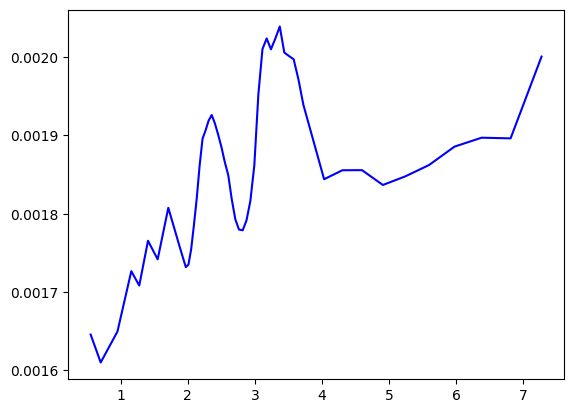

In [8]:
plt.plot(wavelengths, spectra_ideal[0],color='b')
plt.show()

## Modify the training spectra


### Adding noise

Create three new databases with three different levels of Gaussian noise: 10 ppm, 30 ppm, 50 ppm.

In [9]:
errors10ppm = 1e-5*np.ones(52)
errors20ppm = 2e-5*np.ones(52)
errors30ppm = 3e-5*np.ones(52)
errors50ppm = 5e-5*np.ones(52)

np.random.seed(42)
spectra_noise_10ppm = np.random.normal(spectra_ideal, errors10ppm)
spectra_noise_20ppm = np.random.normal(spectra_ideal, errors20ppm)
spectra_noise_30ppm = np.random.normal(spectra_ideal, errors30ppm)
spectra_noise_50ppm = np.random.normal(spectra_ideal, errors50ppm)

Reset negative values from sampling the Gaussian to zero, which is the simplest solution.

In [10]:
for i in range(105887):
  for j in range(52):
    if spectra_noise_10ppm[i,j]<0:
      spectra_noise_10ppm[i,j]=0
    if spectra_noise_20ppm[i,j]<0:
      spectra_noise_20ppm[i,j]=0
    if spectra_noise_30ppm[i,j]<0:
      spectra_noise_30ppm[i,j]=0
    if spectra_noise_50ppm[i,j]<0:
      spectra_noise_50ppm[i,j]=0

### Clean the data: remove very small signals

Compute the maximal bin value for each planet

In [11]:
spectra_ideal_max = np.max(spectra_ideal, axis=1)

We will get rid of all the planets to the left of the vertical red line

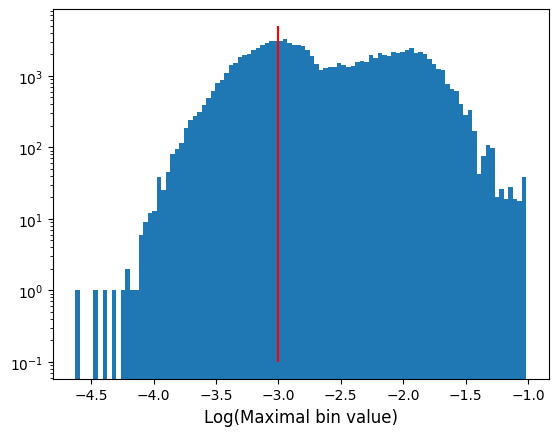

In [12]:
plt.hist(np.log10(spectra_ideal_max), bins=100)
plt.vlines(np.log10(1e-3),0.1,5000,color='r')
plt.xlabel('Log(Maximal bin value)', fontsize=12)
plt.yscale('log')

We are essentially cutting away planets with $\left(\frac{R_p}{R_s}\right)^2<10^{-3}$

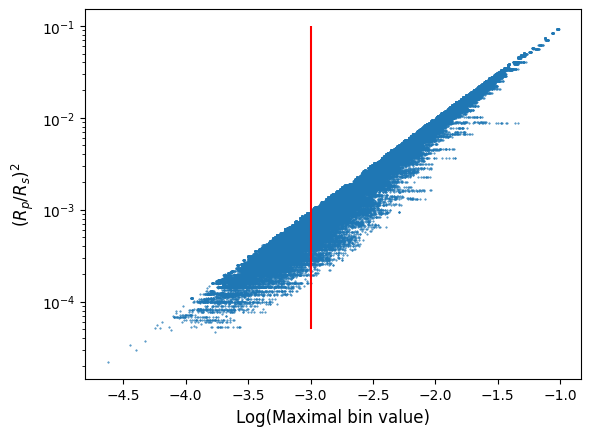

In [13]:
plt.scatter(np.log10(spectra_ideal_max), (aux[:,7]/aux[:,2])**2,  s=0.2)
plt.vlines(np.log10(1e-3),0.00005,0.1,color='r')
plt.xlabel('Log(Maximal bin value)', fontsize=12)
plt.ylabel(r'$(R_p/R_s)^2$', fontsize=12)
plt.yscale('log')
plt.show()

### Create the cleaned dataset

In [14]:
ind_clean = spectra_ideal_max > 1e-3
Nclean = ind_clean.sum()
print('Remaining planets in the dataset:',Nclean)

Remaining planets in the dataset: 74882


In [15]:
ind_clean = aux[:,7]>(0.13*Rplanet)
print('Remaining planets in the dataset:',ind_clean.sum())

Remaining planets in the dataset: 105887


In [16]:
spectra_clean_ideal1 = spectra_ideal[ind_clean]
spectra_clean_10ppm1 = spectra_noise_10ppm[ind_clean]
spectra_clean_20ppm1 = spectra_noise_20ppm[ind_clean]
spectra_clean_30ppm1 = spectra_noise_30ppm[ind_clean]
spectra_clean_50ppm1 = spectra_noise_50ppm[ind_clean]

In [17]:
feature_height_clean1 = np.max(spectra_clean_ideal1,axis=1)-np.min(spectra_clean_ideal1,axis=1)
ind_fh = feature_height_clean1>2.1e-4
Nclean = ind_fh.sum()
feature_height_clean = feature_height_clean1[ind_fh]

In [18]:
np.sum(ind_fh)

69099

In [19]:
spectra_clean_ideal = spectra_clean_ideal1[ind_fh]
spectra_clean_10ppm = spectra_clean_10ppm1[ind_fh]
spectra_clean_20ppm = spectra_clean_20ppm1[ind_fh]
spectra_clean_30ppm = spectra_clean_30ppm1[ind_fh]
spectra_clean_50ppm = spectra_clean_50ppm1[ind_fh]

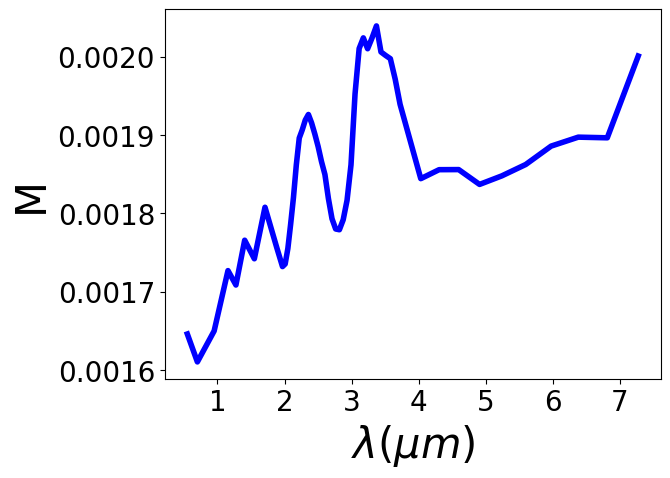

In [20]:
plt.plot(wavelengths, spectra_ideal[0],color='b',lw=4)
plt.xlabel(r'$\lambda (\mu m)$',size=30)
plt.ylabel('M',size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('transmission_spectra_example.png',bbox_inches='tight')

In [21]:
FM_clean1 = FM[ind_clean]
aux_clean1 = aux[ind_clean]
FM_clean = FM_clean1[ind_fh]
aux_clean = aux_clean1[ind_fh]

print('Clean FM  shape:', FM_clean.shape)
print('Clean aux shape:', aux_clean.shape)

Clean FM  shape: (69099, 6)
Clean aux shape: (69099, 9)


<ipython-input-22-57a4d2dac0e2>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


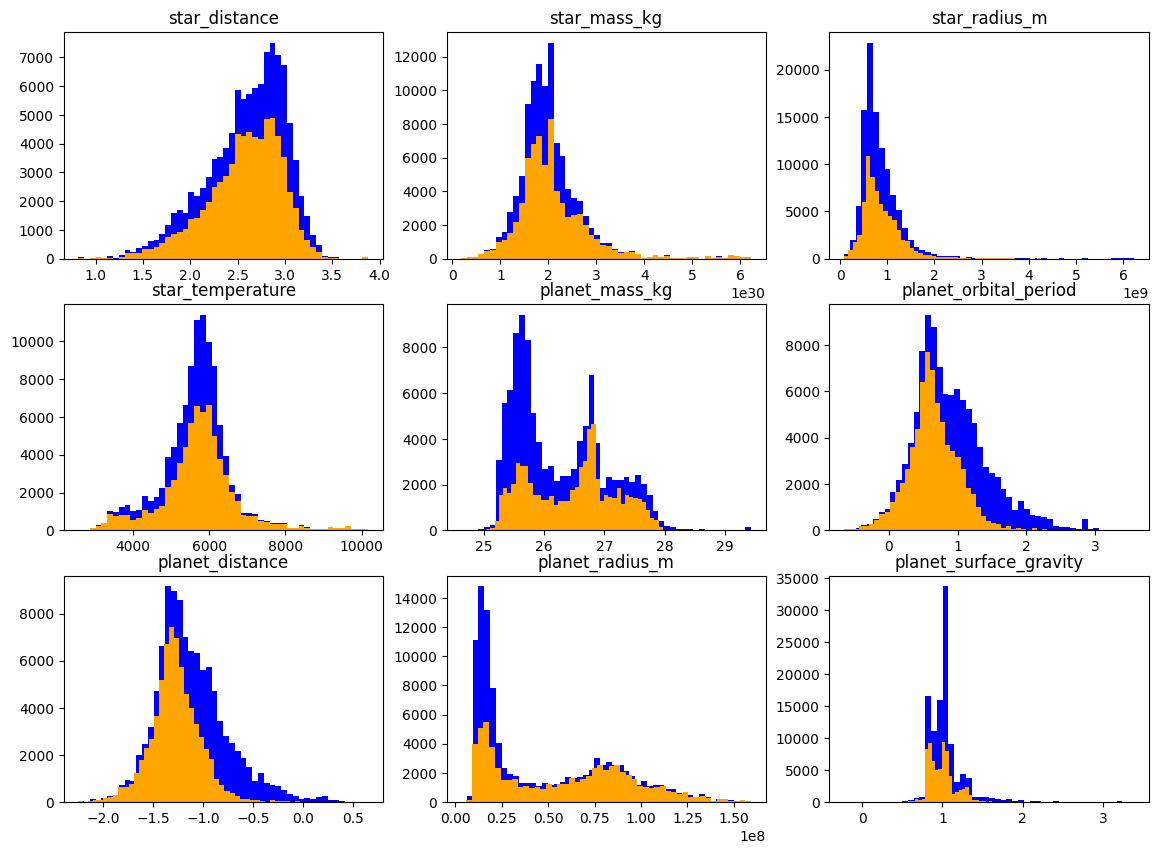

In [22]:
plt.subplots(2,3,figsize = (14,10))
for i in range(aux_clean.shape[1]):
  plt.subplot(3,3,i+1)
  if i in [0,4,5,6,8]:
    plt.hist(np.log10(aux[:,i]),color='b',bins=50)
    plt.hist(np.log10(aux_clean[:,i]),color='orange',bins=50)
  else:
    plt.hist(aux[:,i],color='b',bins=50)
    plt.hist(aux_clean[:,i],color='orange',bins=50)
  plt.title(aux_data.keys()[i])

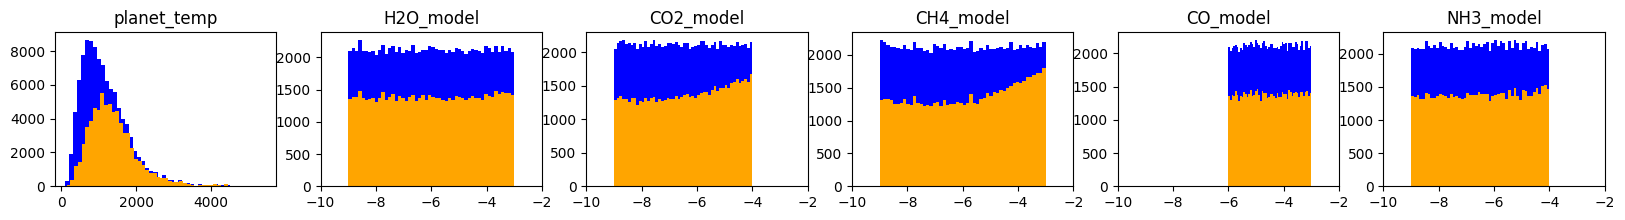

In [155]:
plt.subplots(1,6,figsize = (20,2))
for i in range(FM_clean.shape[1]):
  plt.subplot(1,6,i+1)
  plt.hist(FM[:,i],color='b',bins=50)
  plt.hist(FM_clean[:,i],color='orange',bins=50)
  if i>0:
    plt.xlim([-10,-2])
  plt.title(FM_data.keys()[i])

Plot the feature height vs the mean transit depth with different noise level cut options.

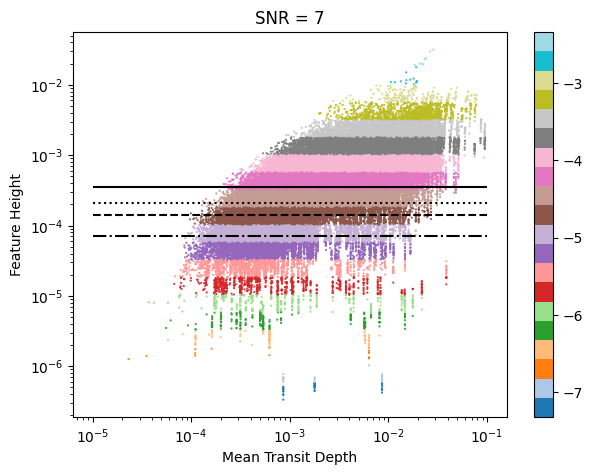

In [24]:
plt.figure(figsize=(7,5))
feature_height = np.max(spectra_ideal,axis=1)-np.min(spectra_ideal,axis=1)
plt.scatter(np.mean(spectra_ideal,axis=1),feature_height,c=np.log10((feature_height)/7),s=0.3,cmap='tab20')
plt.hlines(7*1e-5,xmin=1e-5,xmax=1e-1,linestyle='-.',color='black')
plt.hlines(7*2e-5,xmin=1e-5,xmax=1e-1,linestyle='dashed',color='black')
plt.hlines(7*3e-5,xmin=1e-5,xmax=1e-1,linestyle='dotted',color='black')
plt.hlines(7*5e-5,xmin=1e-5,xmax=1e-1,linestyle='solid',color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean Transit Depth')
plt.ylabel('Feature Height')
plt.title('SNR = 7')
plt.colorbar()

Plot the best and the worst case remaining, i.e. the planets with the largest and smallest signal to noise ratios, respectively.

In [25]:
jbest  = np.argmax(np.max(spectra_clean_ideal, axis=1))
jworst = np.argmin(np.max(spectra_clean_ideal, axis=1))

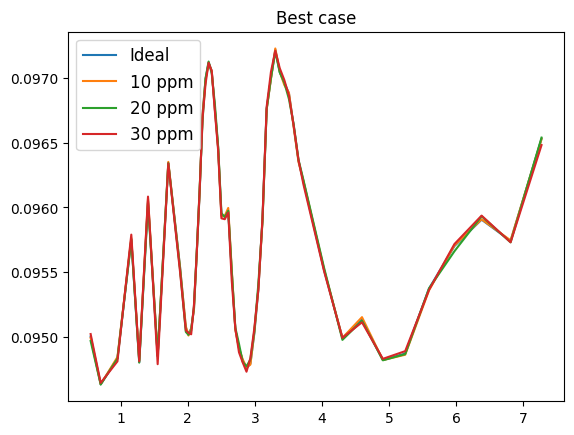

In [26]:
j = jbest
plt.plot(wavelengths,spectra_clean_ideal[j,:], label='Ideal')
plt.plot(wavelengths,spectra_clean_10ppm[j,:], label='10 ppm')
plt.plot(wavelengths,spectra_clean_20ppm[j,:], label='20 ppm')
plt.plot(wavelengths,spectra_clean_30ppm[j,:], label='30 ppm')
plt.title('Best case')
plt.legend(fontsize=12)
plt.show()

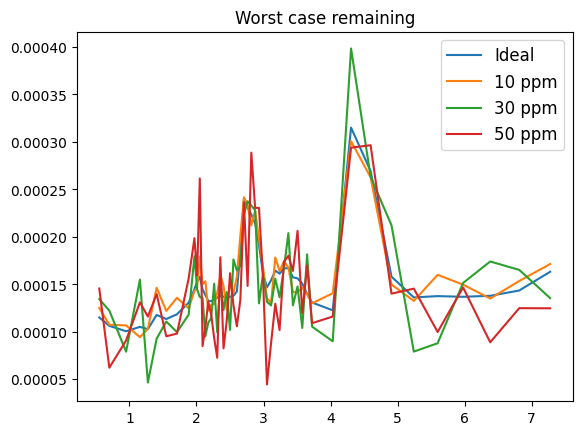

In [27]:
j = jworst
plt.plot(wavelengths,spectra_clean_ideal[j,:], label='Ideal')
plt.plot(wavelengths,spectra_clean_10ppm[j,:], label='10 ppm')
plt.plot(wavelengths,spectra_clean_30ppm[j,:], label='30 ppm')
plt.plot(wavelengths,spectra_clean_50ppm[j,:], label='50 ppm')
plt.title('Worst case remaining')
plt.legend(fontsize=12)
plt.show()

In [28]:
spectra_clean_ideal.shape

(69099, 52)

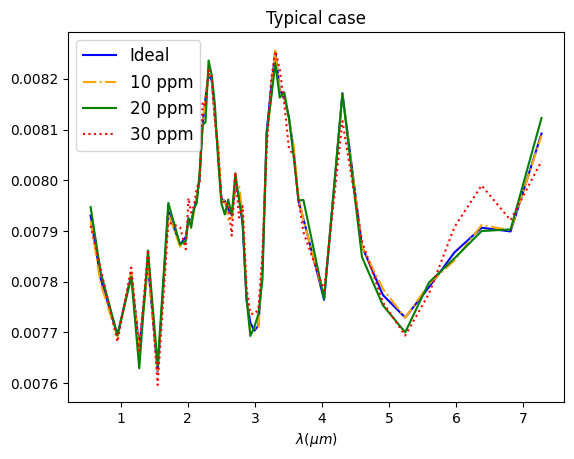

In [29]:
j = 12697
plt.plot(wavelengths,spectra_clean_ideal[j,:], label='Ideal',c='b')
plt.plot(wavelengths,spectra_clean_10ppm[j,:], label='10 ppm',ls='-.',c='orange')
plt.plot(wavelengths,spectra_clean_20ppm[j,:], label='20 ppm',ls='-',c='g')
plt.plot(wavelengths,spectra_clean_30ppm[j,:], label='30 ppm',ls='dotted',c='r')
plt.title('Typical case')
plt.legend(fontsize=12)
plt.xlabel(r'$\lambda(\mu m)$')
plt.show()

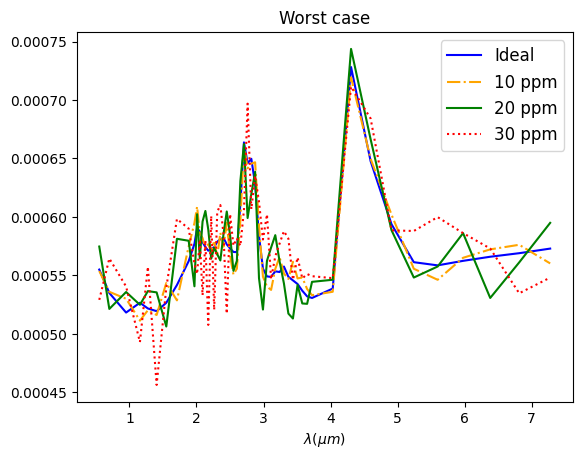

In [30]:
j = 50552
plt.plot(wavelengths,spectra_clean_ideal[j,:], label='Ideal',c='b')
plt.plot(wavelengths,spectra_clean_10ppm[j,:], label='10 ppm',ls='-.',c='orange')
plt.plot(wavelengths,spectra_clean_20ppm[j,:], label='20 ppm',ls='-',c='g')
plt.plot(wavelengths,spectra_clean_30ppm[j,:], label='30 ppm',ls='dotted',c='r')
plt.title('Worst case')
plt.legend(fontsize=12)
plt.xlabel(r'$\lambda(\mu m)$')
plt.show()

# Standardize the spectra

In [31]:
# ideal
x_clean_ideal = np.sqrt(spectra_clean_ideal)
x_clean_ideal_ave = np.mean(x_clean_ideal, axis=1)
x_clean_ideal_std = np.std(x_clean_ideal, axis=1)

x_clean_ideal_cen  = x_clean_ideal - x_clean_ideal_ave.reshape(Nclean,1)
x_clean_ideal_norm = x_clean_ideal_cen / x_clean_ideal_std.reshape(Nclean,1)

# 10 ppm
x_clean_10ppm = np.sqrt(spectra_clean_10ppm)
x_clean_10ppm_ave = np.mean(x_clean_10ppm, axis=1)
x_clean_10ppm_std = np.std(x_clean_10ppm, axis=1)

x_clean_10ppm_cen  = x_clean_10ppm - x_clean_10ppm_ave.reshape(Nclean,1)
x_clean_10ppm_norm = x_clean_10ppm_cen / x_clean_10ppm_std.reshape(Nclean,1)

# 20 ppm
x_clean_20ppm = np.sqrt(spectra_clean_20ppm)
x_clean_20ppm_ave = np.mean(x_clean_20ppm, axis=1)
x_clean_20ppm_std = np.std(x_clean_20ppm, axis=1)

x_clean_20ppm_cen  = x_clean_20ppm - x_clean_20ppm_ave.reshape(Nclean,1)
x_clean_20ppm_norm = x_clean_20ppm_cen / x_clean_20ppm_std.reshape(Nclean,1)

# 30 ppm
x_clean_30ppm = np.sqrt(spectra_clean_30ppm)
x_clean_30ppm_ave = np.mean(x_clean_30ppm, axis=1)
x_clean_30ppm_std = np.std(x_clean_30ppm, axis=1)

x_clean_30ppm_cen  = x_clean_30ppm - x_clean_30ppm_ave.reshape(Nclean,1)
x_clean_30ppm_norm = x_clean_30ppm_cen / x_clean_30ppm_std.reshape(Nclean,1)

# 50 ppm
x_clean_50ppm = np.sqrt(spectra_clean_50ppm)
x_clean_50ppm_ave = np.mean(x_clean_50ppm, axis=1)
x_clean_50ppm_std = np.std(x_clean_50ppm, axis=1)

x_clean_50ppm_cen  = x_clean_50ppm - x_clean_50ppm_ave.reshape(Nclean,1)
x_clean_50ppm_norm = x_clean_50ppm_cen / x_clean_50ppm_std.reshape(Nclean,1)


# Compute concentrations and relative concentrations

In [32]:
ind_fh.shape

(105887,)

In [33]:
conc = 10**FM[ind_clean,1:]
conc = conc[ind_fh,:]
conc_total = np.sum(conc, axis=1)
conc_rel   = conc / conc_total.reshape((Nclean,1))

Plots of the relative concentrations

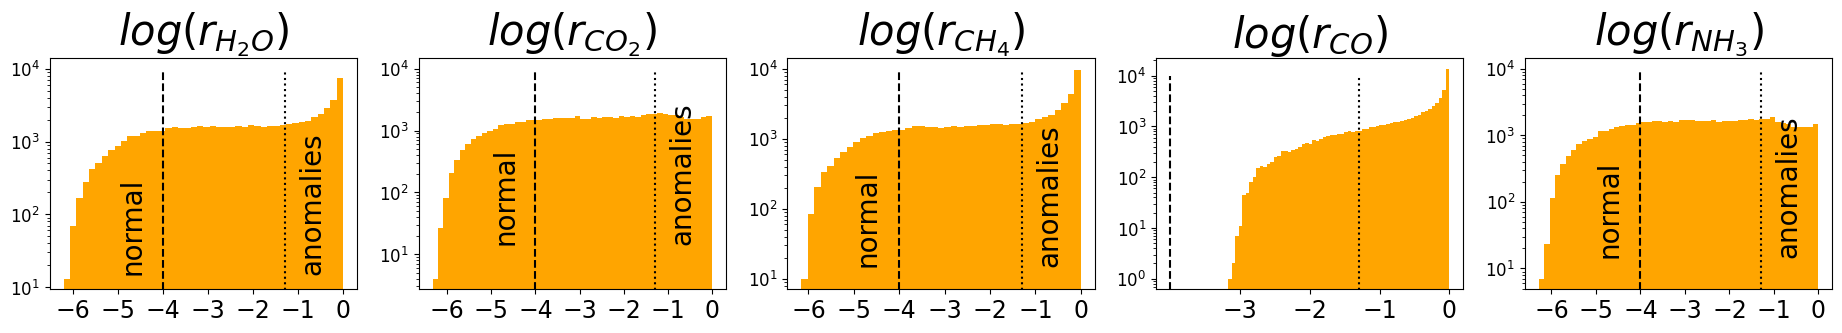

In [34]:
plt.rcParams['figure.figsize'] = [23,3]

titles_par = ['$log(r_{H_2O})$',
              '$log(r_{CO_2}$)',
              '$log(r_{CH_4})$',
              '$log(r_{CO})$',
              '$log(r_{NH_3})$']

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.hist(np.log10(conc_rel[:,i]), 'auto',color='orange')
    plt.xticks(size=17)
    if i==3:
      plt.xticks([0,-1,-2,-3],size=17)
    plt.yticks(size=12)
    plt.yscale('log')
    plt.vlines(-4,0,1e4,linestyles='dashed',color='black')
    plt.vlines(-1.3,0,1e4,linestyles='dotted',color='black')
    plt.title(titles_par[i],fontsize=30)
    if i!=3:
      plt.text(x=-5, y=18, s='normal',color='black',rotation = 'vertical',fontsize=20)#, bbox=dict(facecolor=None,alpha=1))
      plt.text(x=-1, y=18, s='anomalies',color='black',rotation = 'vertical',fontsize=20)
# plt.savefig('relative_conc_distributions.png',bbox_inches='tight')

## Define normal and anomalous samples

Create arrays for different samples:

*   Normal = Dry
*   Anomalous = Wet
*   Mediocre = Moist

Ignore the samples in the mid regions which are 'in between.'

In [35]:
# H2O
i = 0
ind_dry_H20 = conc_rel[:,i] < 1e-4
ind_moi_H20 = np.logical_and(conc_rel[:,i] > 1e-4, conc_rel[:,i] < 0.05)
ind_wet_H20 = conc_rel[:,i] > 0.05

# CO2
i = 1
ind_dry_CO2 = conc_rel[:,i] < 1e-4
ind_moi_CO2 = np.logical_and(conc_rel[:,i] > 1e-4, conc_rel[:,i] < 0.005)
ind_wet_CO2 = conc_rel[:,i] > 0.005

# CH4
i = 2
ind_dry_CH4 = conc_rel[:,i] < 1e-4
ind_moi_CH4 = np.logical_and(conc_rel[:,i] > 1e-4, conc_rel[:,i] < 0.05)
ind_wet_CH4 = conc_rel[:,i] > 0.05

# Skipping the CO case

# NH3
i = 4
ind_dry_NH3 = conc_rel[:,i] < 1e-4
ind_moi_NH3 = np.logical_and(conc_rel[:,i] > 1e-4, conc_rel[:,i] < 0.05)
ind_wet_NH3 = conc_rel[:,i] > 0.05

$NH_3$: create training and testing data.

In [36]:
# For NH3
i = 4
# Centered Spectra (Not using)
# x_cen_dry_NH3 = x_clean_ideal_cen[ind_dry_NH3,:]
# x_cen_moi_NH3 = x_clean_ideal_cen[ind_moi_NH3,:]
# x_cen_wet_NH3 = x_clean_ideal_cen[ind_wet_NH3,:]

# Standardized Spectra
x_norm_dry_NH3 = x_clean_ideal_norm[ind_dry_NH3,:]
x_norm_moi_NH3 = x_clean_ideal_norm[ind_moi_NH3,:]
x_norm_wet_NH3 = x_clean_ideal_norm[ind_wet_NH3,:]
x_norm_dry_NH3_10ppm = x_clean_10ppm_norm[ind_dry_NH3,:]
x_norm_moi_NH3_10ppm = x_clean_10ppm_norm[ind_moi_NH3,:]
x_norm_wet_NH3_10ppm = x_clean_10ppm_norm[ind_wet_NH3,:]
x_norm_dry_NH3_20ppm = x_clean_20ppm_norm[ind_dry_NH3,:]
x_norm_moi_NH3_20ppm = x_clean_20ppm_norm[ind_moi_NH3,:]
x_norm_wet_NH3_20ppm = x_clean_20ppm_norm[ind_wet_NH3,:]
x_norm_dry_NH3_30ppm = x_clean_30ppm_norm[ind_dry_NH3,:]
x_norm_moi_NH3_30ppm = x_clean_30ppm_norm[ind_moi_NH3,:]
x_norm_wet_NH3_30ppm = x_clean_30ppm_norm[ind_wet_NH3,:]
x_norm_dry_NH3_50ppm = x_clean_50ppm_norm[ind_dry_NH3,:]
x_norm_moi_NH3_50ppm = x_clean_50ppm_norm[ind_moi_NH3,:]
x_norm_wet_NH3_50ppm = x_clean_50ppm_norm[ind_wet_NH3,:]

# High signal >10^{-3} spectra FM data = Temp + Concentrations
FM_dry_NH3 = FM_clean[ind_dry_NH3,:]
FM_moi_NH3 = FM_clean[ind_moi_NH3,:]
FM_wet_NH3 = FM_clean[ind_wet_NH3,:]

# Auxilliary paramters
aux_dry_NH3 = aux_clean[ind_dry_NH3,:]
aux_moi_NH3 = aux_clean[ind_moi_NH3,:]
aux_wet_NH3 = aux_clean[ind_wet_NH3,:]

# High Signal >10^{-3} Normal Concentrations only
conc_dry_NH3 = conc[ind_dry_NH3,i]
conc_moi_NH3 = conc[ind_moi_NH3,i]
conc_wet_NH3 = conc[ind_wet_NH3,i]

# High Signal >10^{-3} Relative Concentrations only
conc_rel_dry_NH3 = conc_rel[ind_dry_NH3,i]
conc_rel_moi_NH3 = conc_rel[ind_moi_NH3,i]
conc_rel_wet_NH3 = conc_rel[ind_wet_NH3,i]

In [37]:
FM_dry_NH3.shape[0]+FM_moi_NH3.shape[0]+FM_wet_NH3.shape[0]

69099

In [38]:
FM_dry_NH3.shape

(15833, 6)

In [39]:
FM_moi_NH3.shape

(36978, 6)

In [40]:
FM_wet_NH3.shape

(16288, 6)

Plot the temperature vs the log $NH_3$ concentrations for normal and anomalous (wet) samples:

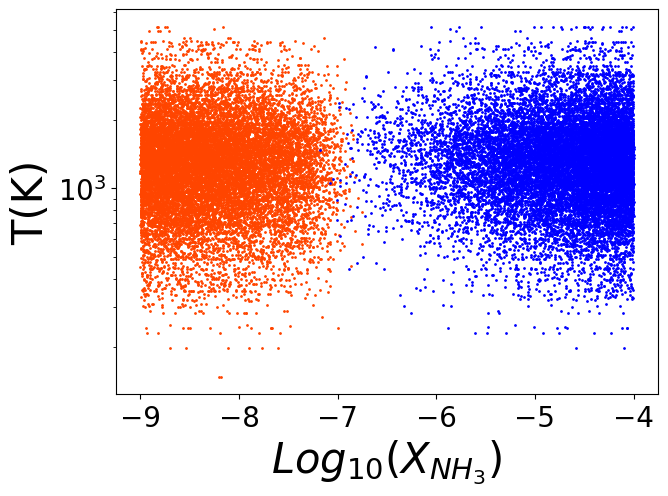

In [41]:
plt.rcParams['figure.figsize'] = [7,5]

temperature = 0
NH3_conc = 5

plt.scatter(FM_dry_NH3[:,NH3_conc], FM_dry_NH3[:,temperature], s=1,c='orangered')
plt.scatter(FM_wet_NH3[:,NH3_conc], FM_wet_NH3[:,temperature], s=1,c='b')

plt.xlabel('$Log_{10} (X_{NH_3})$', fontsize=30)
plt.ylabel('T(K)', fontsize=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.yscale('log')
# plt.savefig('saturated_and_unsaturated_groups.png',bbox_inches='tight')

Plot the temperature vs the relative log $NH_3$ concentrations for normal and anomalous (wet) samples:

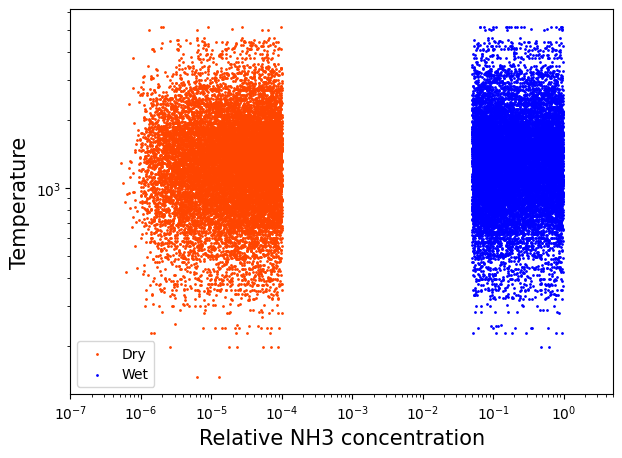

In [42]:
plt.rcParams['figure.figsize'] = [7,5]

temperature = 0
NH3_conc = 5

plt.scatter(conc_rel_dry_NH3[:], FM_dry_NH3[:,temperature], s=1, label='Dry', c='orangered')
plt.scatter(conc_rel_wet_NH3[:], FM_wet_NH3[:,temperature], s=1, label='Wet', c='b')

plt.xlabel('Relative NH3 concentration', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.xlim(1e-7,5)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

$CH_4$: create training and testing data.

In [43]:
# For CH4
i = 2
# Centered Spectra (Not using)
# x_cen_dry_NH3 = x_clean_ideal_cen[ind_dry_NH3,:]
# x_cen_moi_NH3 = x_clean_ideal_cen[ind_moi_NH3,:]
# x_cen_wet_NH3 = x_clean_ideal_cen[ind_wet_NH3,:]

# Standardized Spectra
x_norm_dry_CH4 = x_clean_ideal_norm[ind_dry_CH4,:]
x_norm_moi_CH4 = x_clean_ideal_norm[ind_moi_CH4,:]
x_norm_wet_CH4 = x_clean_ideal_norm[ind_wet_CH4,:]
x_norm_dry_CH4_10ppm = x_clean_10ppm_norm[ind_dry_CH4,:]
x_norm_moi_CH4_10ppm = x_clean_10ppm_norm[ind_moi_CH4,:]
x_norm_wet_CH4_10ppm = x_clean_10ppm_norm[ind_wet_CH4,:]
x_norm_dry_CH4_20ppm = x_clean_20ppm_norm[ind_dry_CH4,:]
x_norm_moi_CH4_20ppm = x_clean_20ppm_norm[ind_moi_CH4,:]
x_norm_wet_CH4_20ppm = x_clean_20ppm_norm[ind_wet_CH4,:]
x_norm_dry_CH4_30ppm = x_clean_30ppm_norm[ind_dry_CH4,:]
x_norm_moi_CH4_30ppm = x_clean_30ppm_norm[ind_moi_CH4,:]
x_norm_wet_CH4_30ppm = x_clean_30ppm_norm[ind_wet_CH4,:]
x_norm_dry_CH4_50ppm = x_clean_50ppm_norm[ind_dry_CH4,:]
x_norm_moi_CH4_50ppm = x_clean_50ppm_norm[ind_moi_CH4,:]
x_norm_wet_CH4_50ppm = x_clean_50ppm_norm[ind_wet_CH4,:]

# High signal >10^{-3} spectra FM data = Temp + Concentrations
FM_dry_CH4 = FM_clean[ind_dry_CH4,:]
FM_moi_CH4 = FM_clean[ind_moi_CH4,:]
FM_wet_CH4 = FM_clean[ind_wet_CH4,:]

# Auxilliary paramters
aux_dry_CH4 = aux_clean[ind_dry_CH4,:]
aux_moi_CH4 = aux_clean[ind_moi_CH4,:]
aux_wet_CH4 = aux_clean[ind_wet_CH4,:]

# High Signal >10^{-3} Normal Concentrations only
conc_dry_CH4 = conc[ind_dry_CH4,i]
conc_moi_CH4 = conc[ind_moi_CH4,i]
conc_wet_CH4 = conc[ind_wet_CH4,i]

# High Signal >10^{-3} Relative Concentrations only
conc_rel_dry_CH4 = conc_rel[ind_dry_CH4,i]
conc_rel_moi_CH4 = conc_rel[ind_moi_CH4,i]
conc_rel_wet_CH4 = conc_rel[ind_wet_CH4,i]

In [44]:
FM_dry_CH4.shape[0]+FM_moi_CH4.shape[0]+FM_wet_CH4.shape[0]

69099

$H_2O$: create training and testing data.

In [45]:
# For H20
i = 0
# Centered Spectra (Not using)
# x_cen_dry_NH3 = x_clean_ideal_cen[ind_dry_NH3,:]
# x_cen_moi_NH3 = x_clean_ideal_cen[ind_moi_NH3,:]
# x_cen_wet_NH3 = x_clean_ideal_cen[ind_wet_NH3,:]

# Standardized Spectra
x_norm_dry_H20 = x_clean_ideal_norm[ind_dry_H20,:]
x_norm_moi_H20 = x_clean_ideal_norm[ind_moi_H20,:]
x_norm_wet_H20 = x_clean_ideal_norm[ind_wet_H20,:]
x_norm_dry_H20_10ppm = x_clean_10ppm_norm[ind_dry_H20,:]
x_norm_moi_H20_10ppm = x_clean_10ppm_norm[ind_moi_H20,:]
x_norm_wet_H20_10ppm = x_clean_10ppm_norm[ind_wet_H20,:]
x_norm_dry_H20_20ppm = x_clean_20ppm_norm[ind_dry_H20,:]
x_norm_moi_H20_20ppm = x_clean_20ppm_norm[ind_moi_H20,:]
x_norm_wet_H20_20ppm = x_clean_20ppm_norm[ind_wet_H20,:]
x_norm_dry_H20_30ppm = x_clean_30ppm_norm[ind_dry_H20,:]
x_norm_moi_H20_30ppm = x_clean_30ppm_norm[ind_moi_H20,:]
x_norm_wet_H20_30ppm = x_clean_30ppm_norm[ind_wet_H20,:]
x_norm_dry_H20_50ppm = x_clean_50ppm_norm[ind_dry_H20,:]
x_norm_moi_H20_50ppm = x_clean_50ppm_norm[ind_moi_H20,:]
x_norm_wet_H20_50ppm = x_clean_50ppm_norm[ind_wet_H20,:]

# High signal >10^{-3} spectra FM data = Temp + Concentrations
FM_dry_H20 = FM_clean[ind_dry_H20,:]
FM_moi_H20 = FM_clean[ind_moi_H20,:]
FM_wet_H20 = FM_clean[ind_wet_H20,:]

# Auxilliary paramters
aux_dry_H20 = aux_clean[ind_dry_H20,:]
aux_moi_H20 = aux_clean[ind_moi_H20,:]
aux_wet_H20 = aux_clean[ind_wet_H20,:]

# High Signal >10^{-3} Normal Concentrations only
conc_dry_H20 = conc[ind_dry_H20,i]
conc_moi_H20 = conc[ind_moi_H20,i]
conc_wet_H20 = conc[ind_wet_H20,i]

# High Signal >10^{-3} Relative Concentrations only
conc_rel_dry_H20 = conc_rel[ind_dry_H20,i]
conc_rel_moi_H20 = conc_rel[ind_moi_H20,i]
conc_rel_wet_H20 = conc_rel[ind_wet_H20,i]

$CO_2$: create training and testing data.

In [46]:
# For CO2
i = 1
# Centered Spectra (Not using)
# x_cen_dry_NH3 = x_clean_ideal_cen[ind_dry_NH3,:]
# x_cen_moi_NH3 = x_clean_ideal_cen[ind_moi_NH3,:]
# x_cen_wet_NH3 = x_clean_ideal_cen[ind_wet_NH3,:]

# Standardized Spectra
x_norm_dry_CO2 = x_clean_ideal_norm[ind_dry_CO2,:]
x_norm_moi_CO2 = x_clean_ideal_norm[ind_moi_CO2,:]
x_norm_wet_CO2 = x_clean_ideal_norm[ind_wet_CO2,:]
x_norm_dry_CO2_10ppm = x_clean_10ppm_norm[ind_dry_CO2,:]
x_norm_moi_CO2_10ppm = x_clean_10ppm_norm[ind_moi_CO2,:]
x_norm_wet_CO2_10ppm = x_clean_10ppm_norm[ind_wet_CO2,:]
x_norm_dry_CO2_20ppm = x_clean_20ppm_norm[ind_dry_CO2,:]
x_norm_moi_CO2_20ppm = x_clean_20ppm_norm[ind_moi_CO2,:]
x_norm_wet_CO2_20ppm = x_clean_20ppm_norm[ind_wet_CO2,:]
x_norm_dry_CO2_30ppm = x_clean_30ppm_norm[ind_dry_CO2,:]
x_norm_moi_CO2_30ppm = x_clean_30ppm_norm[ind_moi_CO2,:]
x_norm_wet_CO2_30ppm = x_clean_30ppm_norm[ind_wet_CO2,:]
x_norm_dry_CO2_50ppm = x_clean_50ppm_norm[ind_dry_CO2,:]
x_norm_moi_CO2_50ppm = x_clean_50ppm_norm[ind_moi_CO2,:]
x_norm_wet_CO2_50ppm = x_clean_50ppm_norm[ind_wet_CO2,:]

# High signal >10^{-3} spectra FM data = Temp + Concentrations
FM_dry_CO2 = FM_clean[ind_dry_CO2,:]
FM_moi_CO2 = FM_clean[ind_moi_CO2,:]
FM_wet_CO2 = FM_clean[ind_wet_CO2,:]

# Auxilliary paramters
aux_dry_CO2 = aux_clean[ind_dry_CO2,:]
aux_moi_CO2 = aux_clean[ind_moi_CO2,:]
aux_wet_CO2 = aux_clean[ind_wet_CO2,:]

# High Signal >10^{-3} Normal Concentrations only
conc_dry_CO2 = conc[ind_dry_CO2,i]
conc_moi_CO2 = conc[ind_moi_CO2,i]
conc_wet_CO2 = conc[ind_wet_CO2,i]

# High Signal >10^{-3} Relative Concentrations only
conc_rel_dry_CO2 = conc_rel[ind_dry_CO2,i]
conc_rel_moi_CO2 = conc_rel[ind_moi_CO2,i]
conc_rel_wet_CO2 = conc_rel[ind_wet_CO2,i]

Plot the temperature vs the log concentrations for normal and anomalous (wet) samples for all molecules:

Text(0.5, 1.0, 'Experiment 4')

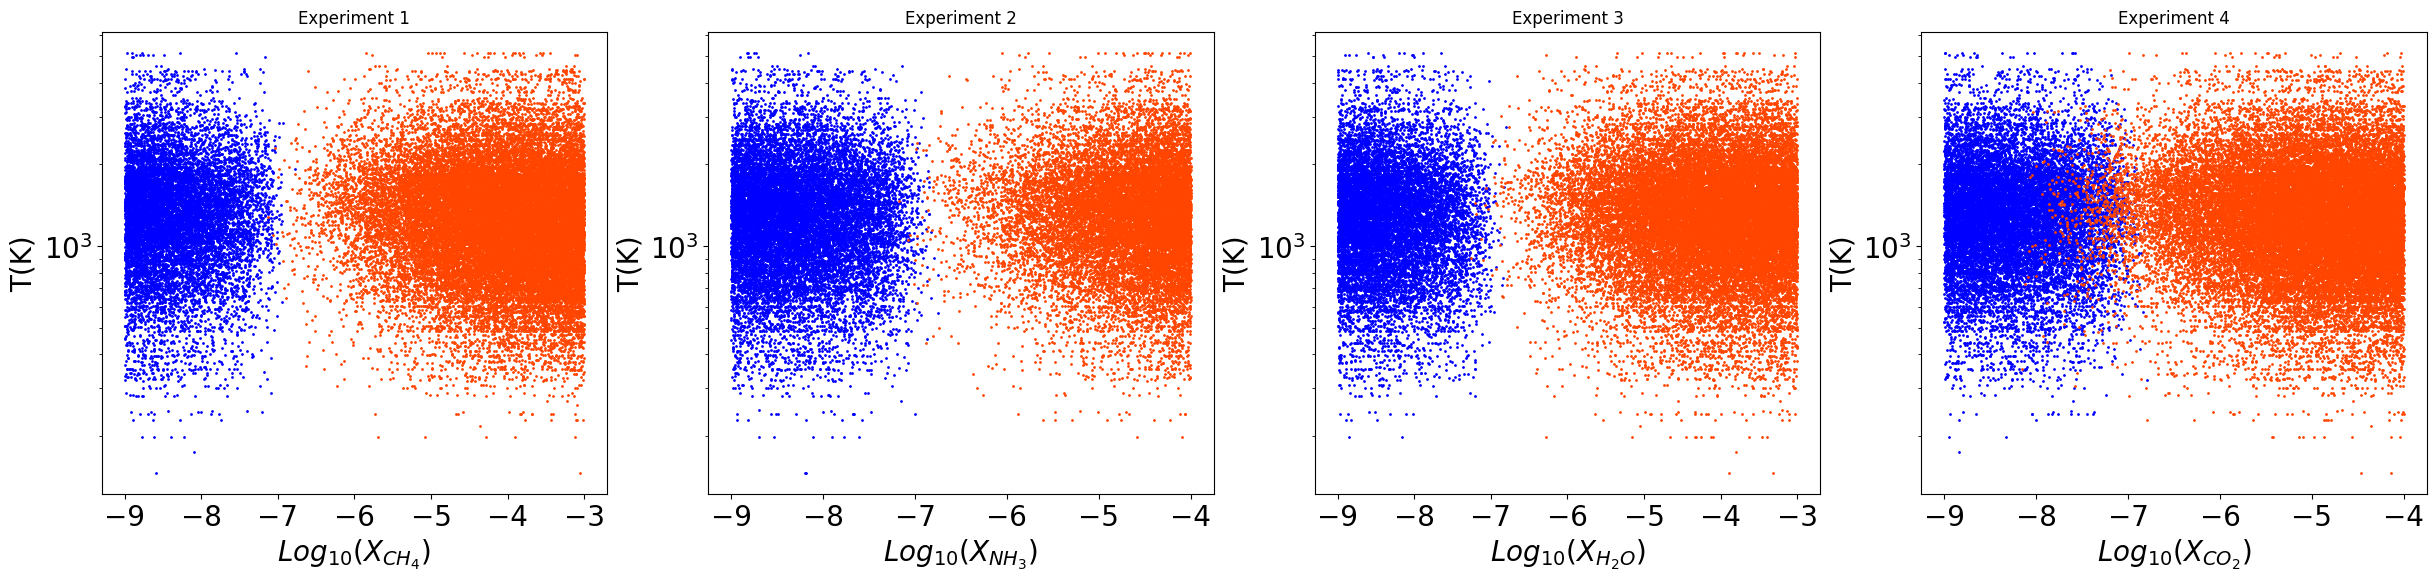

In [47]:
# plt.rcParams['figure.figsize'] = [7,5]


plt.subplots(1,4,figsize=(30,6))


plt.subplot(1,4,1)
CH4_conc = 3

plt.scatter(FM_dry_CH4[:,CH4_conc], FM_dry_CH4[:,temperature], s=1, c='blue')
plt.scatter(FM_wet_CH4[:,CH4_conc], FM_wet_CH4[:,temperature], s=1, c='orangered')

plt.xlabel('$Log_{10} (X_{CH_4})$', fontsize=20)
plt.ylabel('T(K)', fontsize=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.yscale('log')
plt.title('Experiment 1')


plt.subplot(1,4,2)
temperature = 0
NH3_conc = 5

plt.scatter(FM_dry_NH3[:,NH3_conc], FM_dry_NH3[:,temperature], s=1,c='blue')
plt.scatter(FM_wet_NH3[:,NH3_conc], FM_wet_NH3[:,temperature], s=1,c='orangered')

plt.xlabel('$Log_{10} (X_{NH_3})$', fontsize=20)
plt.ylabel('T(K)', fontsize=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.yscale('log')
plt.title('Experiment 2')

plt.subplot(1,4,3)
H20_conc = 1

plt.scatter(FM_dry_H20[:,H20_conc], FM_dry_H20[:,temperature], s=1,c='blue')
plt.scatter(FM_wet_H20[:,H20_conc], FM_wet_H20[:,temperature], s=1,c='orangered')

plt.xlabel('$Log_{10} (X_{H_2O})$', fontsize=20)
plt.ylabel('T(K)', fontsize=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.yscale('log')
plt.title('Experiment 3')

plt.subplot(1,4,4)
CO2_conc = 2

plt.scatter(FM_dry_CO2[:,CO2_conc], FM_dry_CO2[:,temperature], s=1,c='blue')
plt.scatter(FM_wet_CO2[:,CO2_conc], FM_wet_CO2[:,temperature], s=1,c='orangered')

plt.xlabel('$Log_{10} (X_{CO_2})$', fontsize=20)
plt.ylabel('T(K)', fontsize=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.yscale('log')
plt.title('Experiment 4')

# **Novelty Detection Examples: $CH_4$,$NH_3$, $H_2O$, $CO_2$**

###  Note: Training data = dry samples, i.e. dry atmospheres with none of the particular molecule of interest present.

In each of the cases below, we will use a portion of the normal (dry) samples for training and the remaining for testing. We will also use the anomalous (wet) samples for testing.

We define false positive and false negative results as follows:

- FP: Model determines a sample is a novelty (score<value) when it is in the normal testing samples.
- FN: Model determines a sample is normal (score>value) when it is in the anomalous testing samples.
- Error Rate: sum of the number of FP and FN samples divided by the total number of testing samples, i.e. $N_{test} = N_{novelty} + N_{normal}$.

### Method 1 of 3: Local Outlier Factor (LOF)

LOF for $CH_4$

In [48]:
x_norm_dry_CH4.shape

(11169, 52)

In [49]:
from sklearn.neighbors import LocalOutlierFactor

X_train = x_norm_dry_CH4[:9000]
X_test = x_norm_dry_CH4_30ppm[9000:]
X_novelty = x_norm_wet_CH4_30ppm[:X_test.shape[0],:]

n = 22
lof_exp1_CH4_fp = np.zeros(n-1)
lof_exp1_CH4_fn = np.zeros(n-1)
lof_exp1_CH4_error = np.zeros(n-1)
for i in range(1,n,1):
  lof = LocalOutlierFactor(n_neighbors=i, novelty=True)
  lof.fit(X_train)
  limit = np.min(lof.score_samples(X_train))
  limit=-5
  scores_test_lof = lof.score_samples(X_test)
  scores_novelty_lof = lof.score_samples(X_novelty)
  lof_exp1_CH4_fp[i-1] = (scores_test_lof<limit).sum()/X_test.shape[0]
  lof_exp1_CH4_fn[i-1] = (scores_novelty_lof>limit).sum()/X_novelty.shape[0]
  lof_exp1_CH4_error[i-1] = ( (scores_test_lof<limit).sum()+(scores_novelty_lof>limit).sum() )/( X_test.shape[0] + X_novelty.shape[0])

Plot the FP, FN, and Error rates as a function of the number of neighbors in LOF.

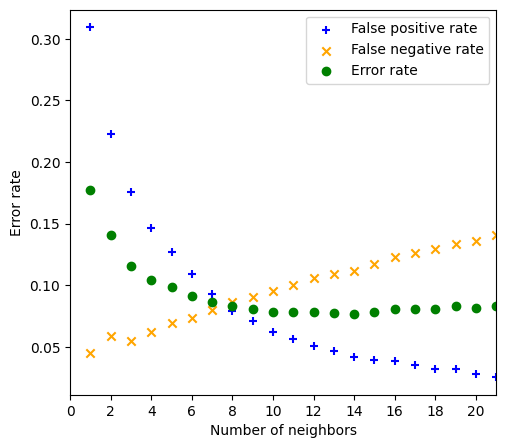

In [50]:
fig = plt.figure(figsize=(5.5,5))
discretization = np.arange(start=1,stop=n)
plt.scatter(discretization,lof_exp1_CH4_fp, c='b',marker = '+',label='False positive rate')
plt.scatter(discretization,lof_exp1_CH4_fn, c='orange',marker = 'x',label='False negative rate')
plt.scatter(discretization,lof_exp1_CH4_error, c='green',marker = 'o',label='Error rate')
plt.xlabel('Number of neighbors')
plt.ylabel('Error rate')
plt.xlim(0,21)
plt.xticks(ticks=[i for i in range(0,21,2)])
plt.legend()

In [51]:
CH4_tr = 9000
X_train = x_norm_dry_CH4[:CH4_tr]

lof = LocalOutlierFactor(n_neighbors=10, novelty=True)
lof.fit(X_train)
limit = np.min(lof.score_samples(X_train))

# ideal CH4
X_test = x_norm_dry_CH4[CH4_tr:]
X_novelty = x_norm_wet_CH4[:X_test.shape[0],:]
scores_test_lof_ideal = lof.score_samples(X_test)
scores_novelty_lof_ideal = lof.score_samples(X_novelty)

# 10 ppm CH4
X_test = x_norm_dry_CH4_10ppm[CH4_tr:]
X_novelty = x_norm_wet_CH4_10ppm[:X_test.shape[0],:]
scores_test_lof_10ppm = lof.score_samples(X_test)
scores_novelty_lof_10ppm = lof.score_samples(X_novelty)

# 20 ppm CH4
X_test = x_norm_dry_CH4_20ppm[CH4_tr:]
X_novelty = x_norm_wet_CH4_20ppm[:X_test.shape[0],:]
scores_test_lof_20ppm = lof.score_samples(X_test)
scores_novelty_lof_20ppm = lof.score_samples(X_novelty)

# 30 ppm CH4
X_test = x_norm_dry_CH4_30ppm[CH4_tr:]
X_novelty = x_norm_wet_CH4_30ppm[:X_test.shape[0],:]
scores_test_lof_30ppm = lof.score_samples(X_test)
scores_novelty_lof_30ppm = lof.score_samples(X_novelty)

# 50 ppm CH4
X_test = x_norm_dry_CH4_50ppm[CH4_tr:]
X_novelty = x_norm_wet_CH4_50ppm[:X_test.shape[0],:]
scores_test_lof_50ppm = lof.score_samples(X_test)
scores_novelty_lof_50ppm = lof.score_samples(X_novelty)

Histograms of scores for normal and anomalous samples at different noise levels

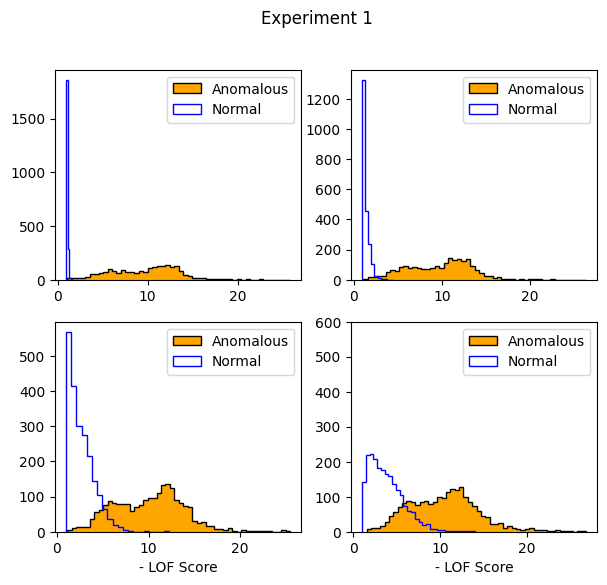

In [52]:
plt.subplots(2,2,figsize=(7,6))
plt.subplot(2,2,1)
plt.hist(-scores_novelty_lof_ideal,bins=50,color='orange',edgecolor='black',histtype='step',facecolor='orange',fill=True,label='Anomalous')
plt.hist(-scores_test_lof_ideal,bins=5,edgecolor='b', histtype='step', facecolor='g',label='Normal')#fill=False,hatch=None)
plt.legend()

plt.subplot(2,2,2)
plt.hist(-scores_novelty_lof_10ppm,bins=50,color='orange',edgecolor='black',histtype='step',facecolor='orange',fill=True,label='Anomalous')
plt.hist(-scores_test_lof_10ppm,bins=10,edgecolor='b', histtype='step', facecolor='g',label='Normal')#fill=False,hatch=None)
plt.legend()

plt.subplot(2,2,3)
plt.hist(-scores_novelty_lof_30ppm,bins=50,color='orange',edgecolor='black',histtype='step',facecolor='orange',fill=True,label='Anomalous')
plt.hist(-scores_test_lof_30ppm,bins=20,edgecolor='b', histtype='step', facecolor='g',label='Normal')#fill=False,hatch=None)
plt.xlabel('- LOF Score')
plt.legend()

plt.subplot(2,2,4)
plt.hist(-scores_novelty_lof_50ppm,bins=50,color='orange',edgecolor='black',histtype='step',facecolor='orange',fill=True,label='Anomalous')
plt.hist(-scores_test_lof_50ppm,bins=30,edgecolor='b', histtype='step', facecolor='g',label='Normal')#fill=False,hatch=None)
plt.ylim(0,600)
plt.legend()
plt.xlabel('- LOF Score')
plt.suptitle('Experiment 1')
plt.show()

Scatter plots of the true log concentration values vs. the negative LOF scores at different noise levels. The normal points are colored black and the novel points are colored by their log relative concentrations.

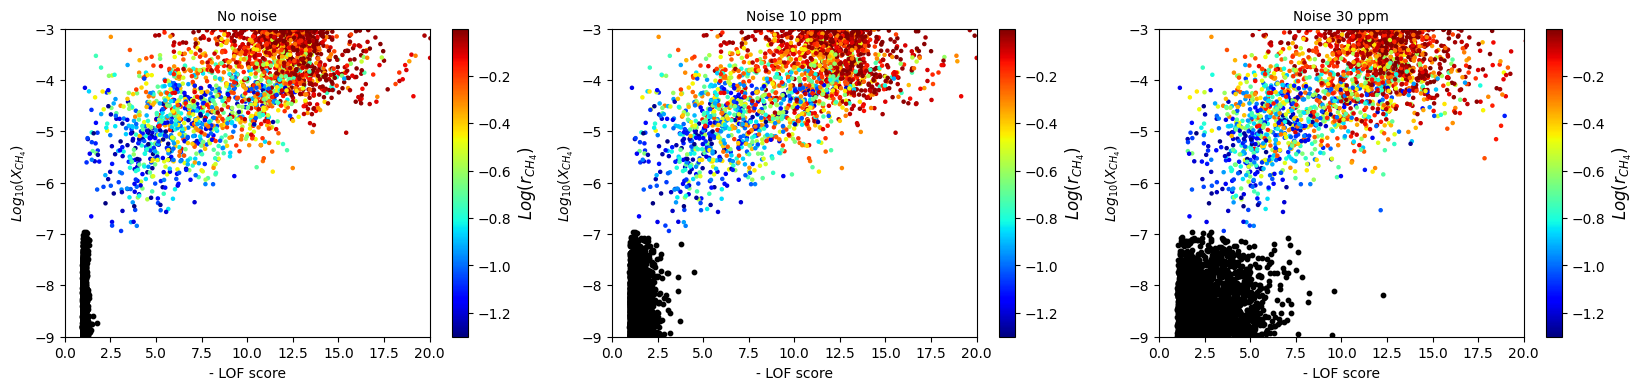

In [53]:
plt.subplots(1,3,figsize=(20,4))
plt.subplot(1,3,1)
plt.scatter( -scores_test_lof_ideal,FM_dry_CH4[CH4_tr:,CH4_conc], c='black', s=10)
im = plt.scatter( -scores_novelty_lof_ideal, FM_wet_CH4[:X_test.shape[0],CH4_conc], c=np.log10(conc_rel_wet_CH4[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('- LOF score',fontsize=10)
plt.ylabel('$Log_{10}(X_{CH_4})$',fontsize=10)
plt.title('No noise',fontsize=10)
plt.xlim(0,20)
plt.ylim(-9,-3)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{CH_4})$')
cb.set_label(label='$Log(r_{CH_4})$', size='large', weight='bold')

plt.subplot(1,3,2)
plt.scatter( -scores_test_lof_10ppm,FM_dry_CH4[CH4_tr:,CH4_conc], c='black', s=10)
im = plt.scatter( -scores_novelty_lof_10ppm, FM_wet_CH4[:X_test.shape[0],CH4_conc], c=np.log10(conc_rel_wet_CH4[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('- LOF score',fontsize=10)
plt.ylabel('$Log_{10}(X_{CH_4})$',fontsize=10)
plt.title('Noise 10 ppm',fontsize=10)
plt.xlim(0,20)
plt.ylim(-9,-3)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{CH_4})$')
cb.set_label(label='$Log(r_{CH_4})$', size='large', weight='bold')


plt.subplot(1,3,3)
plt.scatter( -scores_test_lof_30ppm,FM_dry_CH4[CH4_tr:,CH4_conc], c='black', s=10)
im = plt.scatter( -scores_novelty_lof_30ppm, FM_wet_CH4[:X_test.shape[0],CH4_conc], c=np.log10(conc_rel_wet_CH4[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('- LOF score',fontsize=10)
plt.ylabel('$Log_{10}(X_{CH_4})$',fontsize=10)
plt.title('Noise 30 ppm',fontsize=10)
plt.xlim(0,20)
plt.ylim(-9,-3)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{CH_4})$')
cb.set_label(label='$Log(r_{CH_4})$', size='large', weight='bold')
# plt.savefig('lof_novelty_scatter.png',bbox_inches='tight')

In [54]:
X_train = x_norm_dry_CH4[:CH4_tr]

test_list = [x_norm_dry_CH4,
             x_norm_dry_CH4_10ppm,
             x_norm_dry_CH4_20ppm,
             x_norm_dry_CH4_30ppm,
             x_norm_dry_CH4_50ppm]

train_list = [x_norm_wet_CH4,
              x_norm_wet_CH4_10ppm,
              x_norm_wet_CH4_20ppm,
              x_norm_wet_CH4_30ppm,
              x_norm_wet_CH4_50ppm]

n = 200
lof_exp1_CH4_fp = np.zeros((5,n))
lof_exp1_CH4_tp = np.zeros((5,n))
limits = -np.linspace(start=0,stop=30,num=n)
lof = LocalOutlierFactor(n_neighbors=10, novelty=True)
lof.fit(X_train)


for item in range(5):
  X_test = test_list[item][CH4_tr:]
  X_novelty = train_list[item][:X_test.shape[0],:]
  scores_test_lof = lof.score_samples(X_test)
  scores_novelty_lof = lof.score_samples(X_novelty)
  for i in range(n):
    limit=limits[i]
    lof_exp1_CH4_fp[item,i] = (scores_test_lof<limit).sum()/X_test.shape[0]
    lof_exp1_CH4_tp[item,i] = (scores_novelty_lof<limit).sum()/X_novelty.shape[0]

ROC Curves for different LOF training cases with different levels of noise.

Text(0, 0.5, 'True Positive Rate')

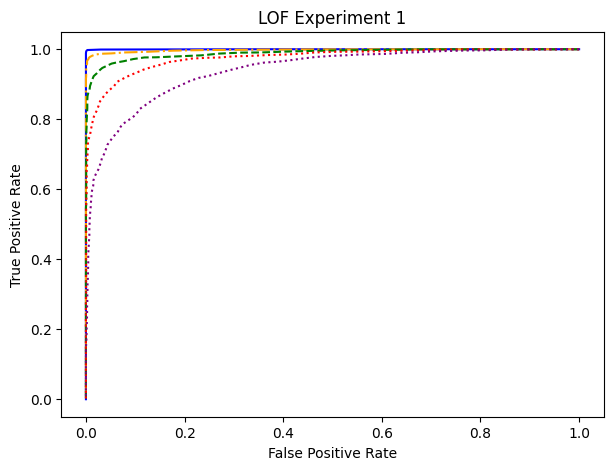

In [55]:
plt.plot(lof_exp1_CH4_fp[0],lof_exp1_CH4_tp[0],c='b',label='No noise')
plt.plot(lof_exp1_CH4_fp[1],lof_exp1_CH4_tp[1],c='orange',ls='-.',label='10 ppm')
plt.plot(lof_exp1_CH4_fp[2],lof_exp1_CH4_tp[2],c='g',ls='--',label='20 ppm')
plt.plot(lof_exp1_CH4_fp[3],lof_exp1_CH4_tp[3],c='r',ls='dotted',label='30 ppm')
plt.plot(lof_exp1_CH4_fp[4],lof_exp1_CH4_tp[4],c='purple',ls='dotted',label='50 ppm')
plt.title('LOF Experiment 1')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

LOF for $NH_3$

In [56]:
NH3_tr = 13000
X_train = x_norm_dry_NH3[:NH3_tr]

lof = LocalOutlierFactor(n_neighbors=10, novelty=True)
lof.fit(X_train)
limit = np.min(lof.score_samples(X_train))

# ideal NH3
X_test = x_norm_dry_NH3[NH3_tr:]
X_novelty = x_norm_wet_NH3[:X_test.shape[0],:]
scores_test_lof_ideal = lof.score_samples(X_test)
scores_novelty_lof_ideal = lof.score_samples(X_novelty)

# 10 ppm NH3
X_test = x_norm_dry_NH3_10ppm[NH3_tr:]
X_novelty = x_norm_wet_NH3_10ppm[:X_test.shape[0],:]
scores_test_lof_10ppm = lof.score_samples(X_test)
scores_novelty_lof_10ppm = lof.score_samples(X_novelty)

# 20 ppm NH3
X_test = x_norm_dry_NH3_20ppm[NH3_tr:]
X_novelty = x_norm_wet_NH3_20ppm[:X_test.shape[0],:]
scores_test_lof_20ppm = lof.score_samples(X_test)
scores_novelty_lof_20ppm = lof.score_samples(X_novelty)

# 30 ppm NH3
X_test = x_norm_dry_NH3_30ppm[NH3_tr:]
X_novelty = x_norm_wet_NH3_30ppm[:X_test.shape[0],:]
scores_test_lof_30ppm = lof.score_samples(X_test)
scores_novelty_lof_30ppm = lof.score_samples(X_novelty)

# 50 ppm NH3
X_test = x_norm_dry_NH3_50ppm[NH3_tr:]
X_novelty = x_norm_wet_NH3_50ppm[:X_test.shape[0],:]
scores_test_lof_50ppm = lof.score_samples(X_test)
scores_novelty_lof_50ppm = lof.score_samples(X_novelty)

Scatter plots of the true log concentration values vs. the negative LOF scores at different noise levels. The normal points are colored black and the novel points are colored by their log relative concentrations.

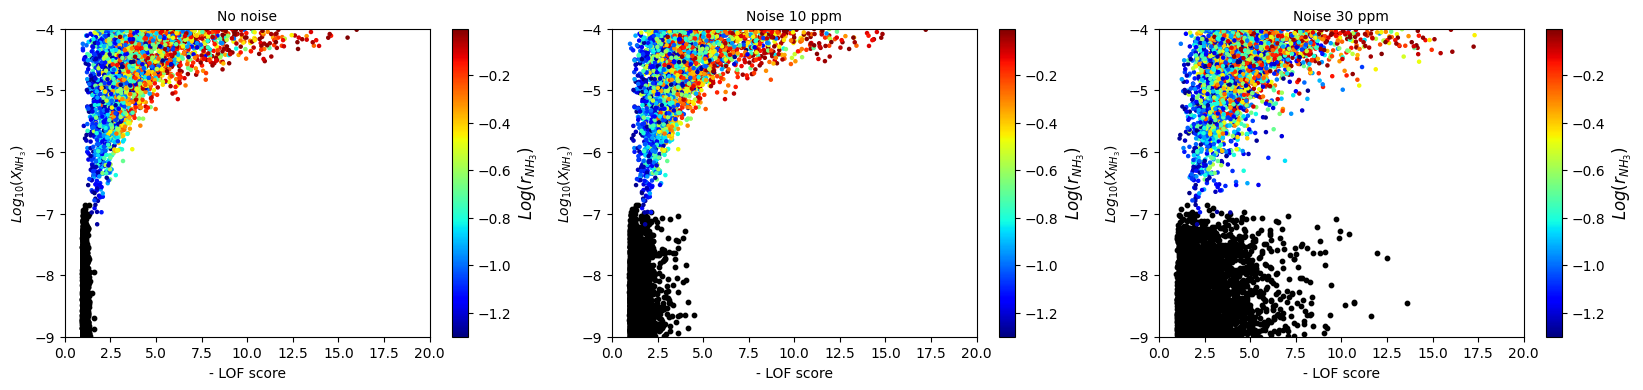

In [57]:
plt.subplots(1,3,figsize=(20,4))
plt.subplot(1,3,1)
plt.scatter( -scores_test_lof_ideal,FM_dry_NH3[NH3_tr:,NH3_conc], c='black', s=10)
im = plt.scatter( -scores_novelty_lof_ideal, FM_wet_NH3[:X_test.shape[0],NH3_conc], c=np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('- LOF score',fontsize=10)
plt.ylabel('$Log_{10}(X_{NH_3})$',fontsize=10)
plt.title('No noise',fontsize=10)
plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{NH_3})$')
cb.set_label(label='$Log(r_{NH_3})$', size='large', weight='bold')

plt.subplot(1,3,2)
plt.scatter( -scores_test_lof_10ppm,FM_dry_NH3[NH3_tr:,NH3_conc], c='black', s=10)
im = plt.scatter( -scores_novelty_lof_10ppm, FM_wet_NH3[:X_test.shape[0],NH3_conc], c=np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('- LOF score',fontsize=10)
plt.ylabel('$Log_{10}(X_{NH_3})$',fontsize=10)
plt.title('Noise 10 ppm',fontsize=10)
plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{NH_3})$')
cb.set_label(label='$Log(r_{NH_3})$', size='large', weight='bold')


plt.subplot(1,3,3)
plt.scatter( -scores_test_lof_30ppm,FM_dry_NH3[NH3_tr:,NH3_conc], c='black', s=10)
im = plt.scatter( -scores_novelty_lof_30ppm, FM_wet_NH3[:X_test.shape[0],NH3_conc], c=np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('- LOF score',fontsize=10)
plt.ylabel('$Log_{10}(X_{NH_3})$',fontsize=10)
plt.title('Noise 30 ppm',fontsize=10)
plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{NH_3})$')
cb.set_label(label='$Log(r_{NH_3})$', size='large', weight='bold')
# plt.savefig('lof_novelty_scatter.png',bbox_inches='tight')

In [58]:
X_train = x_norm_dry_NH3[:NH3_tr]


test_list = [x_norm_dry_NH3,
             x_norm_dry_NH3_10ppm,
             x_norm_dry_NH3_20ppm,
             x_norm_dry_NH3_30ppm,
             x_norm_dry_NH3_50ppm]

train_list = [x_norm_wet_NH3,
              x_norm_wet_NH3_10ppm,
              x_norm_wet_NH3_20ppm,
              x_norm_wet_NH3_30ppm,
              x_norm_wet_NH3_50ppm]

n = 200
lof_exp1_NH3_fp = np.zeros((5,n))
lof_exp1_NH3_tp = np.zeros((5,n))
limits = -np.linspace(start=0,stop=30,num=n)
lof = LocalOutlierFactor(n_neighbors=10, novelty=True)
lof.fit(X_train)


for item in range(5):
  X_test = test_list[item][NH3_tr:]
  X_novelty = train_list[item][:X_test.shape[0],:]
  scores_test_lof = lof.score_samples(X_test)
  scores_novelty_lof = lof.score_samples(X_novelty)
  for i in range(n):
    limit=limits[i]
    lof_exp1_NH3_fp[item,i] = (scores_test_lof<limit).sum()/X_test.shape[0]
    lof_exp1_NH3_tp[item,i] = (scores_novelty_lof<limit).sum()/X_novelty.shape[0]

ROC Curves for different LOF training cases with different levels of noise.

Text(0, 0.5, 'True Positive Rate')

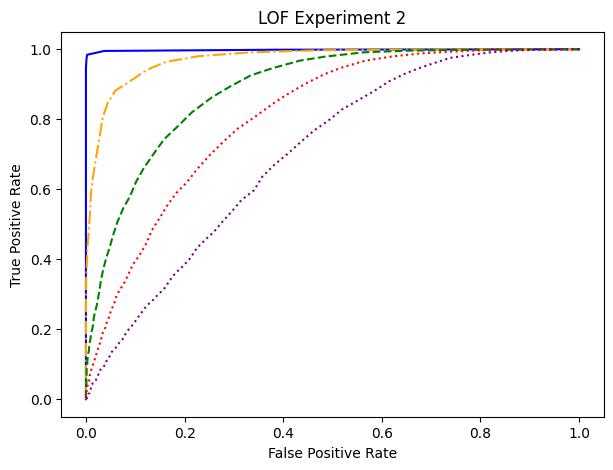

In [59]:
plt.plot(lof_exp1_NH3_fp[0],lof_exp1_NH3_tp[0],c='b',label='No noise')
plt.plot(lof_exp1_NH3_fp[1],lof_exp1_NH3_tp[1],c='orange',ls='-.',label='10 ppm')
plt.plot(lof_exp1_NH3_fp[2],lof_exp1_NH3_tp[2],c='g',ls='--',label='20 ppm')
plt.plot(lof_exp1_NH3_fp[3],lof_exp1_NH3_tp[3],c='r',ls='dotted',label='30 ppm')
plt.plot(lof_exp1_NH3_fp[4],lof_exp1_NH3_tp[4],c='purple',ls='dotted',label='50 ppm')
plt.title('LOF Experiment 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

LOF for $H_2O$

In [60]:
H2O_tr = 10000
X_train = x_norm_dry_H20[:H2O_tr]

lof = LocalOutlierFactor(n_neighbors=10, novelty=True)
lof.fit(X_train)
limit = np.min(lof.score_samples(X_train))

# ideal H2O
X_test = x_norm_dry_H20[H2O_tr:]
X_novelty = x_norm_wet_H20[:X_test.shape[0],:]
scores_test_lof_ideal = lof.score_samples(X_test)
scores_novelty_lof_ideal = lof.score_samples(X_novelty)

# 10 ppm H2O
X_test = x_norm_dry_H20_10ppm[H2O_tr:]
X_novelty = x_norm_wet_H20_10ppm[:X_test.shape[0],:]
scores_test_lof_10ppm = lof.score_samples(X_test)
scores_novelty_lof_10ppm = lof.score_samples(X_novelty)

# 20 ppm H2O
X_test = x_norm_dry_H20_20ppm[H2O_tr:]
X_novelty = x_norm_wet_H20_20ppm[:X_test.shape[0],:]
scores_test_lof_20ppm = lof.score_samples(X_test)
scores_novelty_lof_20ppm = lof.score_samples(X_novelty)

# 30 ppm H2O
X_test = x_norm_dry_H20_30ppm[H2O_tr:]
X_novelty = x_norm_wet_H20_30ppm[:X_test.shape[0],:]
scores_test_lof_30ppm = lof.score_samples(X_test)
scores_novelty_lof_30ppm = lof.score_samples(X_novelty)

# 50 ppm H2O
X_test = x_norm_dry_H20_50ppm[H2O_tr:]
X_novelty = x_norm_wet_H20_50ppm[:X_test.shape[0],:]
scores_test_lof_50ppm = lof.score_samples(X_test)
scores_novelty_lof_50ppm = lof.score_samples(X_novelty)

Scatter plots of the true log concentration values vs. the negative LOF scores at different noise levels. The normal points are colored black and the novel points are colored by their log relative concentrations.

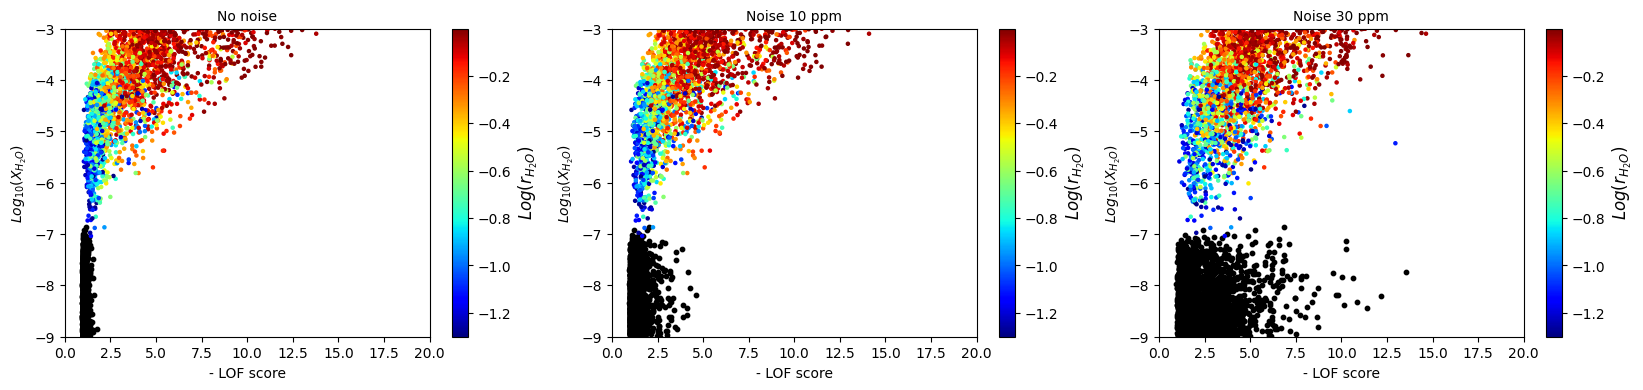

In [61]:
plt.subplots(1,3,figsize=(20,4))
plt.subplot(1,3,1)
plt.scatter( -scores_test_lof_ideal,FM_dry_H20[H2O_tr:,H20_conc], c='black', s=10)
im = plt.scatter( -scores_novelty_lof_ideal, FM_wet_H20[:X_test.shape[0],H20_conc], c=np.log10(conc_rel_wet_H20[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('- LOF score',fontsize=10)
plt.ylabel('$Log_{10}(X_{H_2 O})$',fontsize=10)
plt.title('No noise',fontsize=10)
plt.xlim(0,20)
plt.ylim(-9,-3)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{H_2 O})$')
cb.set_label(label='$Log(r_{H_2 O})$', size='large', weight='bold')

plt.subplot(1,3,2)
plt.scatter( -scores_test_lof_10ppm,FM_dry_H20[H2O_tr:,H20_conc], c='black', s=10)
im = plt.scatter( -scores_novelty_lof_10ppm, FM_wet_H20[:X_test.shape[0],H20_conc], c=np.log10(conc_rel_wet_H20[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('- LOF score',fontsize=10)
plt.ylabel('$Log_{10}(X_{H_2 O})$',fontsize=10)
plt.title('Noise 10 ppm',fontsize=10)
plt.xlim(0,20)
plt.ylim(-9,-3)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{H_2 O})$')
cb.set_label(label='$Log(r_{H_2 O})$', size='large', weight='bold')


plt.subplot(1,3,3)
plt.scatter( -scores_test_lof_30ppm,FM_dry_H20[H2O_tr:,H20_conc], c='black', s=10)
im = plt.scatter( -scores_novelty_lof_30ppm, FM_wet_H20[:X_test.shape[0],H20_conc], c=np.log10(conc_rel_wet_H20[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('- LOF score',fontsize=10)
plt.ylabel('$Log_{10}(X_{H_2 O})$',fontsize=10)
plt.title('Noise 30 ppm',fontsize=10)
plt.xlim(0,20)
plt.ylim(-9,-3)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{H_2 O})$')
cb.set_label(label='$Log(r_{H_2 O})$', size='large', weight='bold')
# plt.savefig('lof_novelty_scatter.png',bbox_inches='tight')

In [62]:
X_train = x_norm_dry_H20[:H2O_tr]

test_list = [x_norm_dry_H20,
             x_norm_dry_H20_10ppm,
             x_norm_dry_H20_20ppm,
             x_norm_dry_H20_30ppm,
             x_norm_dry_H20_50ppm]

train_list = [x_norm_wet_H20,
              x_norm_wet_H20_10ppm,
              x_norm_wet_H20_20ppm,
              x_norm_wet_H20_30ppm,
              x_norm_wet_H20_50ppm]

n = 200
lof_exp1_H2O_fp = np.zeros((5,n))
lof_exp1_H2O_tp = np.zeros((5,n))
limits = -np.linspace(start=0,stop=30,num=n)
lof = LocalOutlierFactor(n_neighbors=10, novelty=True)
lof.fit(X_train)


for item in range(5):
  X_test = test_list[item][H2O_tr:]
  X_novelty = train_list[item][:X_test.shape[0],:]
  scores_test_lof = lof.score_samples(X_test)
  scores_novelty_lof = lof.score_samples(X_novelty)
  for i in range(n):
    limit=limits[i]
    lof_exp1_H2O_fp[item,i] = (scores_test_lof<limit).sum()/X_test.shape[0]
    lof_exp1_H2O_tp[item,i] = (scores_novelty_lof<limit).sum()/X_novelty.shape[0]

ROC Curves for different LOF training cases with different levels of noise.

Text(0, 0.5, 'True Positive Rate')

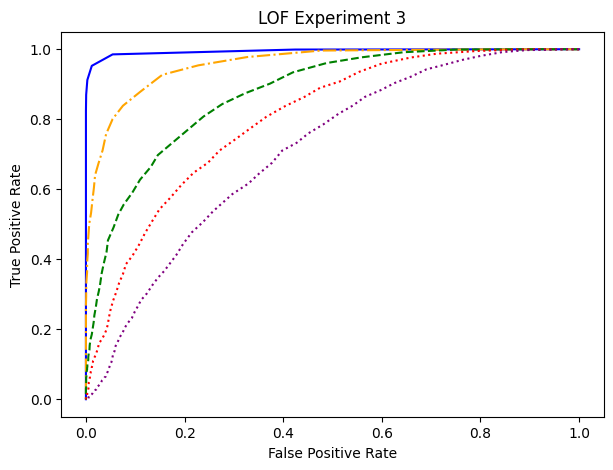

In [63]:
plt.plot(lof_exp1_H2O_fp[0],lof_exp1_H2O_tp[0],c='b',label='No noise')
plt.plot(lof_exp1_H2O_fp[1],lof_exp1_H2O_tp[1],c='orange',ls='-.',label='10 ppm')
plt.plot(lof_exp1_H2O_fp[2],lof_exp1_H2O_tp[2],c='g',ls='--',label='20 ppm')
plt.plot(lof_exp1_H2O_fp[3],lof_exp1_H2O_tp[3],c='r',ls='dotted',label='30 ppm')
plt.plot(lof_exp1_H2O_fp[4],lof_exp1_H2O_tp[4],c='purple',ls='dotted',label='50 ppm')
plt.title('LOF Experiment 3')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

LOF of $CO_2$

In [64]:
CO2_tr = 13000
X_train = x_norm_dry_CO2[:CO2_tr]

lof = LocalOutlierFactor(n_neighbors=10, novelty=True)
lof.fit(X_train)
limit = np.min(lof.score_samples(X_train))

# ideal CO2
X_test = x_norm_dry_CO2[CO2_tr:]
X_novelty = x_norm_wet_CO2[:X_test.shape[0],:]
scores_test_lof_ideal = lof.score_samples(X_test)
scores_novelty_lof_ideal = lof.score_samples(X_novelty)

# 10 ppm CO2
X_test = x_norm_dry_CO2_10ppm[CO2_tr:]
X_novelty = x_norm_wet_CO2_10ppm[:X_test.shape[0],:]
scores_test_lof_10ppm = lof.score_samples(X_test)
scores_novelty_lof_10ppm = lof.score_samples(X_novelty)

# 20 ppm CO2
X_test = x_norm_dry_CO2_20ppm[CO2_tr:]
X_novelty = x_norm_wet_CO2_20ppm[:X_test.shape[0],:]
scores_test_lof_20ppm = lof.score_samples(X_test)
scores_novelty_lof_20ppm = lof.score_samples(X_novelty)

# 30 ppm CO2
X_test = x_norm_dry_CO2_30ppm[CO2_tr:]
X_novelty = x_norm_wet_CO2_30ppm[:X_test.shape[0],:]
scores_test_lof_30ppm = lof.score_samples(X_test)
scores_novelty_lof_30ppm = lof.score_samples(X_novelty)

# 50 ppm CO2
X_test = x_norm_dry_CO2_50ppm[CO2_tr:]
X_novelty = x_norm_wet_CO2_50ppm[:X_test.shape[0],:]
scores_test_lof_50ppm = lof.score_samples(X_test)
scores_novelty_lof_50ppm = lof.score_samples(X_novelty)

Histograms of scores for normal and anomalous samples at different noise levels

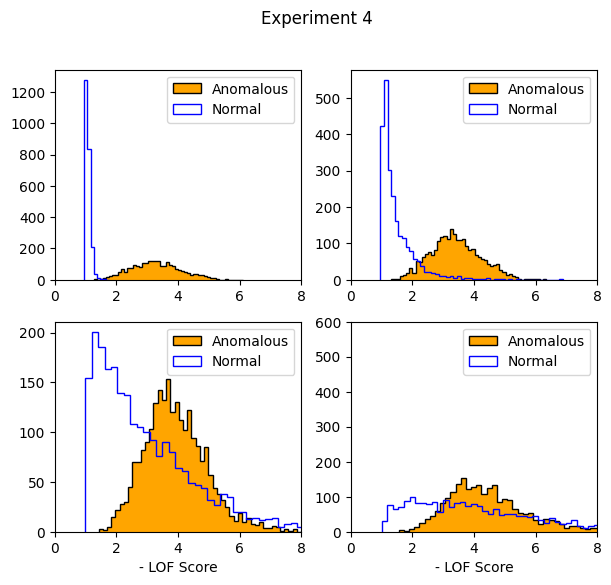

In [65]:
plt.subplots(2,2,figsize=(7,6))
plt.subplot(2,2,1)
plt.hist(-scores_novelty_lof_ideal,bins=50,color='orange',edgecolor='black',histtype='step',facecolor='orange',fill=True,label='Anomalous')
plt.hist(-scores_test_lof_ideal,bins=8,edgecolor='b', histtype='step', facecolor='g',label='Normal')#fill=False,hatch=None)
plt.xlim(0,8)
plt.legend()

plt.subplot(2,2,2)
plt.hist(-scores_novelty_lof_10ppm,bins=50,color='orange',edgecolor='black',histtype='step',facecolor='orange',fill=True,label='Anomalous')
plt.hist(-scores_test_lof_10ppm,bins=50,edgecolor='b', histtype='step', facecolor='g',label='Normal')#fill=False,hatch=None)
plt.xlim(0,8)
plt.legend()

plt.subplot(2,2,3)
plt.hist(-scores_novelty_lof_30ppm,bins=80,color='orange',edgecolor='black',histtype='step',facecolor='orange',fill=True,label='Anomalous')
plt.hist(-scores_test_lof_30ppm,bins=70,edgecolor='b', histtype='step', facecolor='g',label='Normal')#fill=False,hatch=None)
plt.xlim(0,8)
plt.xlabel('- LOF Score')
plt.legend()

plt.subplot(2,2,4)
plt.hist(-scores_novelty_lof_50ppm,bins=100,color='orange',edgecolor='black',histtype='step',facecolor='orange',fill=True,label='Anomalous')
plt.hist(-scores_test_lof_50ppm,bins=120,edgecolor='b', histtype='step', facecolor='g',label='Normal')#fill=False,hatch=None)
plt.ylim(0,600)
plt.legend()
plt.suptitle('Experiment 4')
plt.xlim(0,8)
plt.xlabel('- LOF Score')
plt.show()

Scatter plots of the true log concentration values vs. the negative LOF scores at different noise levels. The normal points are colored black and the novel points are colored by their log relative concentrations.

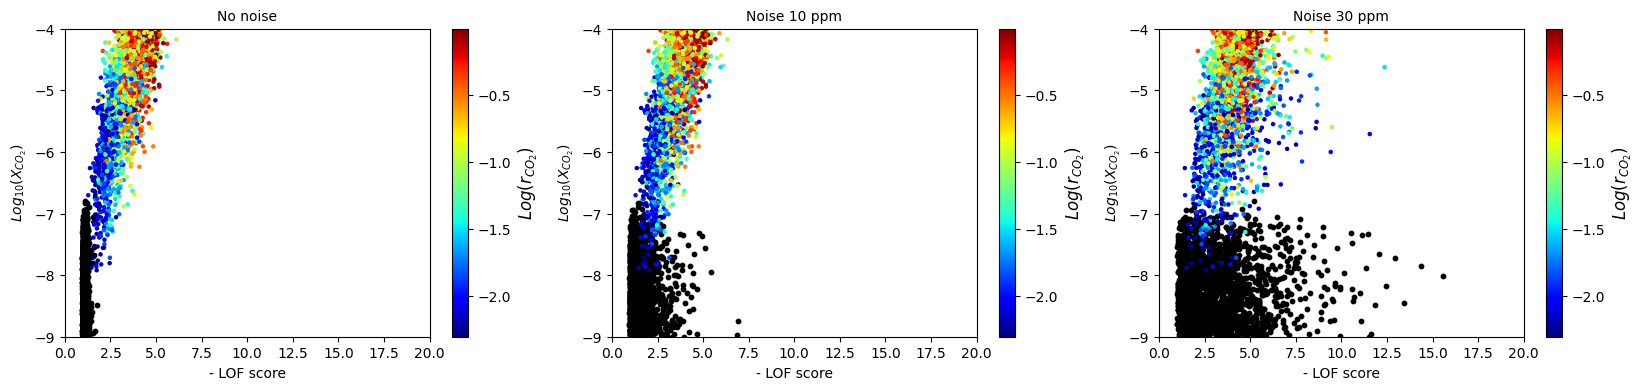

In [66]:
plt.subplots(1,3,figsize=(20,4))
plt.subplot(1,3,1)
plt.scatter( -scores_test_lof_ideal,FM_dry_CO2[CO2_tr:,CO2_conc], c='black', s=10)
im = plt.scatter( -scores_novelty_lof_ideal, FM_wet_CO2[:X_test.shape[0],CO2_conc], c=np.log10(conc_rel_wet_CO2[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('- LOF score',fontsize=10)
plt.ylabel('$Log_{10}(X_{CO_2})$',fontsize=10)
plt.title('No noise',fontsize=10)
plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{CO_2})$')
cb.set_label(label='$Log(r_{CO_2})$', size='large', weight='bold')

plt.subplot(1,3,2)
plt.scatter( -scores_test_lof_10ppm,FM_dry_CO2[CO2_tr:,CO2_conc], c='black', s=10)
im = plt.scatter( -scores_novelty_lof_10ppm, FM_wet_CO2[:X_test.shape[0],CO2_conc], c=np.log10(conc_rel_wet_CO2[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('- LOF score',fontsize=10)
plt.ylabel('$Log_{10}(X_{CO_2})$',fontsize=10)
plt.title('Noise 10 ppm',fontsize=10)
plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{CO_2})$')
cb.set_label(label='$Log(r_{CO_2})$', size='large', weight='bold')


plt.subplot(1,3,3)
plt.scatter( -scores_test_lof_30ppm,FM_dry_CO2[CO2_tr:,CO2_conc], c='black', s=10)
im = plt.scatter( -scores_novelty_lof_30ppm, FM_wet_CO2[:X_test.shape[0],CO2_conc], c=np.log10(conc_rel_wet_CO2[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('- LOF score',fontsize=10)
plt.ylabel('$Log_{10}(X_{CO_2})$',fontsize=10)
plt.title('Noise 30 ppm',fontsize=10)
plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{CO_2})$')
cb.set_label(label='$Log(r_{CO_2})$', size='large', weight='bold')
# plt.savefig('lof_novelty_scatter.png',bbox_inches='tight')

In [67]:
X_train = x_norm_dry_CO2[:CO2_tr]

test_list = [x_norm_dry_CO2,
             x_norm_dry_CO2_10ppm,
             x_norm_dry_CO2_20ppm,
             x_norm_dry_CO2_30ppm,
             x_norm_dry_CO2_50ppm]

train_list = [x_norm_wet_CO2,
              x_norm_wet_CO2_10ppm,
              x_norm_wet_CO2_20ppm,
              x_norm_wet_CO2_30ppm,
              x_norm_wet_CO2_50ppm]

n = 200
lof_exp1_CO2_fp = np.zeros((5,n))
lof_exp1_CO2_tp = np.zeros((5,n))
limits = -np.linspace(start=0,stop=30,num=n)
lof = LocalOutlierFactor(n_neighbors=10, novelty=True)
lof.fit(X_train)


for item in range(5):
  X_test = test_list[item][CO2_tr:]
  X_novelty = train_list[item][:X_test.shape[0],:]
  scores_test_lof = lof.score_samples(X_test)
  scores_novelty_lof = lof.score_samples(X_novelty)
  for i in range(n):
    limit=limits[i]
    lof_exp1_CO2_fp[item,i] = (scores_test_lof<limit).sum()/X_test.shape[0]
    lof_exp1_CO2_tp[item,i] = (scores_novelty_lof<limit).sum()/X_novelty.shape[0]

ROC Curves for different LOF training cases with different levels of noise.

Text(0, 0.5, 'True Positive Rate')

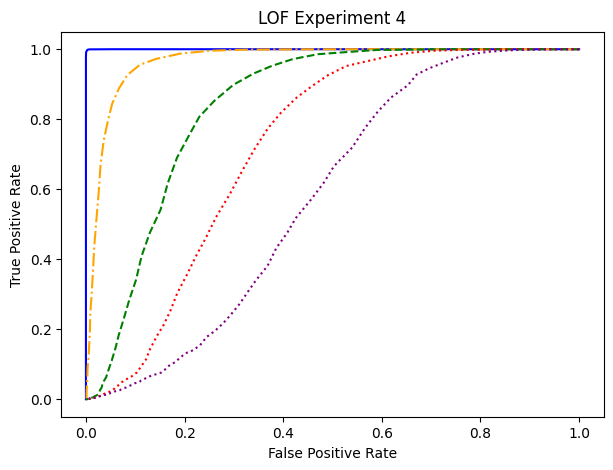

In [68]:
plt.plot(lof_exp1_CO2_fp[0],lof_exp1_CO2_tp[0],c='b',label='No noise')
plt.plot(lof_exp1_CO2_fp[1],lof_exp1_CO2_tp[1],c='orange',ls='-.',label='10 ppm')
plt.plot(lof_exp1_CO2_fp[2],lof_exp1_CO2_tp[2],c='g',ls='--',label='20 ppm')
plt.plot(lof_exp1_CO2_fp[3],lof_exp1_CO2_tp[3],c='r',ls='dotted',label='30 ppm')
plt.plot(lof_exp1_CO2_fp[4],lof_exp1_CO2_tp[4],c='purple',ls='dotted',label='50 ppm')
plt.title('LOF Experiment 4')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [69]:
NH3_tr = 13000
X_train = x_norm_dry_NH3[:NH3_tr]

# ideal NH3
X_test = x_norm_dry_NH3[NH3_tr:]
X_novelty = x_norm_wet_NH3[:X_test.shape[0],:]

In [70]:
lof = LocalOutlierFactor(n_neighbors=10, novelty=True)
lof.fit(X_train)
limit = np.min(lof.score_samples(X_train))

In [71]:
scores_test_lof = lof.score_samples(X_test)
scores_novelty_lof = lof.score_samples(X_novelty)
scores_moist_lof = lof.score_samples(x_norm_moi_NH3)

In [72]:
accuracy_svm = 1.0-np.sum(scores_test_lof<limit)/X_test.shape[0]
print('Novelty Accuracy: ',accuracy_svm)

Novelty Accuracy:  1.0


In [73]:
error_svm = np.sum(scores_novelty_lof>-0.013)/X_novelty.shape[0]
print('Novelty Error: ',error_svm)

Novelty Error:  0.0


1CSVM histogram

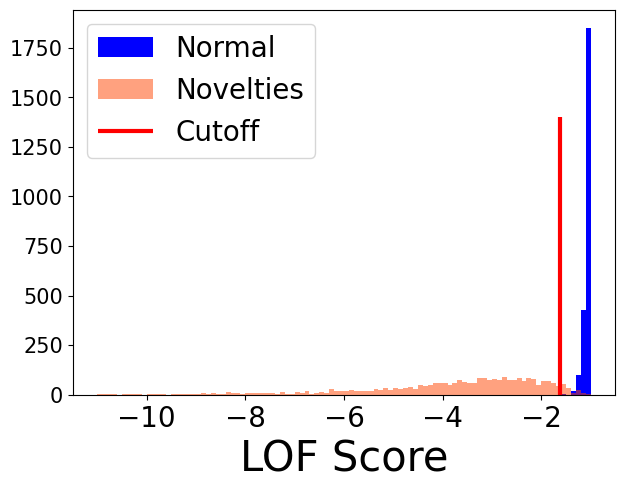

In [74]:
plt.hist(scores_test_lof, bins=np.linspace(-11,-1,101), color='b',label='Normal')
plt.hist(scores_novelty_lof, bins=np.linspace(-11,-1,101), color='orangered',alpha=0.5, label='Novelties')
plt.vlines(-np.max(-scores_test_lof), 0, 1400, colors='r',lw=3,label='Cutoff')
plt.legend(loc='upper left',fontsize = 20)
# plt.yscale('log')
plt.xticks(size=20)
plt.yticks(size=15)
plt.xlabel('LOF Score', fontsize=30)
plt.savefig('lof_novelty_distr.png',bbox_inches = 'tight')

LOF scatter plot

In [75]:
scores_test_lof.shape

(2833,)

In [76]:
FM_dry_NH3[15000:,5].shape

(833,)

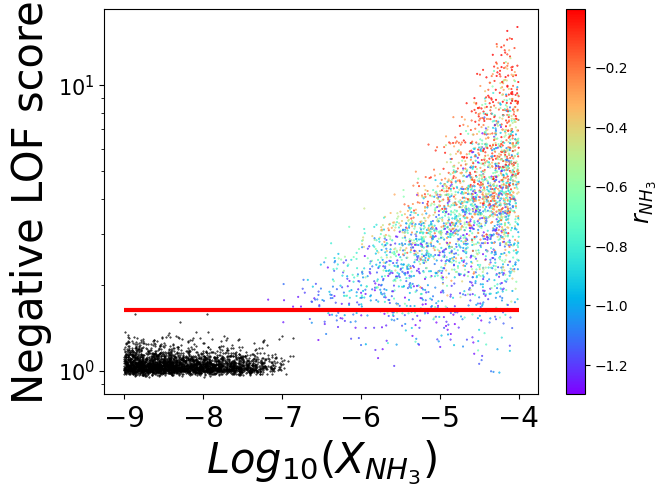

In [77]:
plt.scatter(FM_dry_NH3[NH3_tr:,5], -scores_test_lof, c='black', s=0.2)
im = plt.scatter(FM_wet_NH3[:X_test.shape[0],5], -scores_novelty_lof, c=np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), s=0.2, cmap='rainbow')
plt.xlabel('$Log_{10}(X_{NH_3})$', fontsize=30)
plt.ylabel('Negative LOF score', fontsize=30)
plt.hlines(np.max(-scores_test_lof),-9,-4,color='r',lw=3,label='Cutoff')
plt.xticks(size=20)
plt.yticks(size=15)
plt.yscale('log')
cb = plt.colorbar(im,label='$r_{NH_3}$')
cb.set_label(label='$r_{NH_3}$', size='xx-large', weight='bold')
plt.savefig('lof_novelty_scatter.png',bbox_inches='tight')

Negative LOF score vs relative concentrations colored by normal, middle, and wet samples.

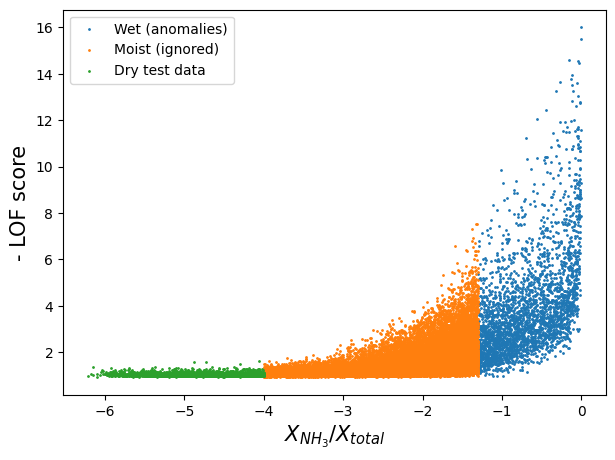

In [78]:
plt.scatter(np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), -scores_novelty_lof, s=1, label='Wet (anomalies)')
plt.scatter(np.log10(conc_rel_moi_NH3[:]), -scores_moist_lof, s=1, label='Moist (ignored)')
plt.scatter(np.log10(conc_rel_dry_NH3[NH3_tr:]), -scores_test_lof, s=1, label='Dry test data')
plt.xlabel('$X_{NH_3}/X_{total}$', fontsize=15)
plt.ylabel('- LOF score', fontsize=15)
# plt.xlim(1e-7,5)
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

### Method 2 of 3: One-Class SVM with RBF Kernel (1CSVM)

In [79]:
from sklearn.svm import OneClassSVM

1CSVM for $CH_4$

In [80]:
CH4_tr = 9000
X_train = x_norm_dry_CH4[:CH4_tr]


svm = OneClassSVM(kernel='rbf',
                degree=3,
                gamma=0.02,
                coef0=0.0,
                tol=0.001,
                nu=0.01,
                shrinking=True,
                cache_size=200,
                verbose=False,
                max_iter=-1)

svm.fit(X_train)

# ideal CH4
X_test = x_norm_dry_CH4[CH4_tr:]
X_novelty = x_norm_wet_CH4[:X_test.shape[0],:]
scores_test_svm_ideal = svm.decision_function(X_test)
scores_novelty_svm_ideal = svm.decision_function(X_novelty)

# 10 ppm CH4
X_test = x_norm_dry_CH4_10ppm[CH4_tr:]
X_novelty = x_norm_wet_CH4_10ppm[:X_test.shape[0],:]
scores_test_svm_10ppm = svm.decision_function(X_test)
scores_novelty_svm_10ppm = svm.decision_function(X_novelty)

# 20 ppm CH4
X_test = x_norm_dry_CH4_20ppm[CH4_tr:]
X_novelty = x_norm_wet_CH4_20ppm[:X_test.shape[0],:]
scores_test_svm_20ppm = svm.decision_function(X_test)
scores_novelty_svm_20ppm = svm.decision_function(X_novelty)

# 30 ppm CH4
X_test = x_norm_dry_CH4_30ppm[CH4_tr:]
X_novelty = x_norm_wet_CH4_30ppm[:X_test.shape[0],:]
scores_test_svm_30ppm = svm.decision_function(X_test)
scores_novelty_svm_30ppm = svm.decision_function(X_novelty)

# 50 ppm CH4
X_test = x_norm_dry_CH4_50ppm[CH4_tr:]
X_novelty = x_norm_wet_CH4_50ppm[:X_test.shape[0],:]
scores_test_svm_50ppm = svm.decision_function(X_test)
scores_novelty_svm_50ppm = svm.decision_function(X_novelty)

Scatter plots of the true log concentration values vs. the 1CSVM scores at different noise levels. The normal points are colored black and the novel points are colored by their log relative concentrations.

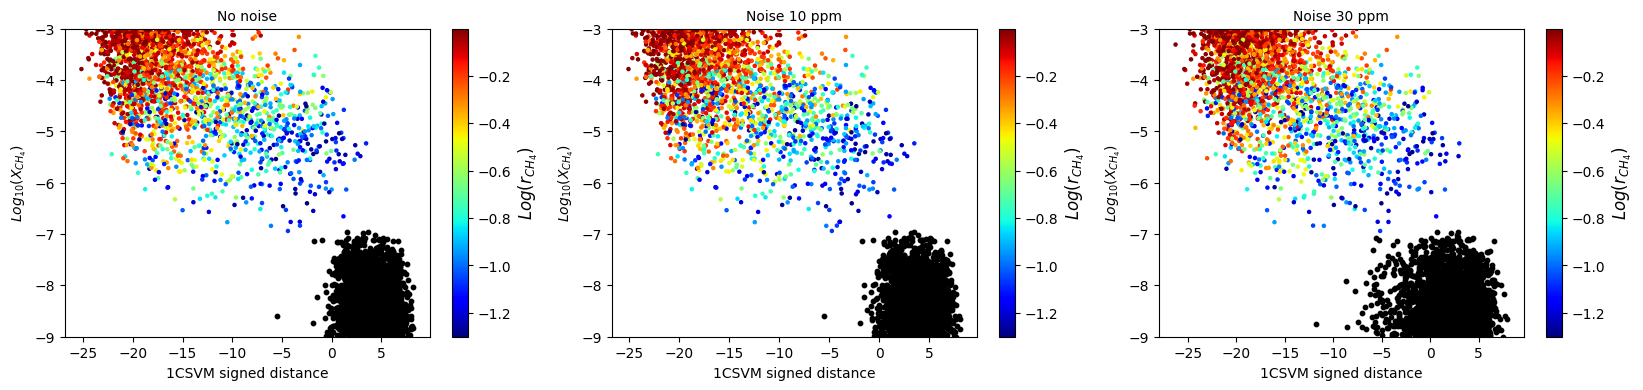

In [81]:
plt.subplots(1,3,figsize=(20,4))
plt.subplot(1,3,1)
plt.scatter( scores_test_svm_ideal,FM_dry_CH4[CH4_tr:,CH4_conc], c='black', s=10)
im = plt.scatter( scores_novelty_svm_ideal, FM_wet_CH4[:X_test.shape[0],CH4_conc], c=np.log10(conc_rel_wet_CH4[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('1CSVM signed distance',fontsize=10)
plt.ylabel('$Log_{10}(X_{CH_4})$',fontsize=10)
plt.title('No noise',fontsize=10)
# plt.xlim(0,20)
plt.ylim(-9,-3)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{CH_4})$')
cb.set_label(label='$Log(r_{CH_4})$', size='large', weight='bold')

plt.subplot(1,3,2)
plt.scatter( scores_test_svm_10ppm,FM_dry_CH4[CH4_tr:,CH4_conc], c='black', s=10)
im = plt.scatter( scores_novelty_svm_10ppm, FM_wet_CH4[:X_test.shape[0],CH4_conc], c=np.log10(conc_rel_wet_CH4[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('1CSVM signed distance',fontsize=10)
plt.ylabel('$Log_{10}(X_{CH_4})$',fontsize=10)
plt.title('Noise 10 ppm',fontsize=10)
# plt.xlim(0,20)
plt.ylim(-9,-3)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{CH_4})$')
cb.set_label(label='$Log(r_{CH_4})$', size='large', weight='bold')


plt.subplot(1,3,3)
plt.scatter( scores_test_svm_30ppm,FM_dry_CH4[CH4_tr:,CH4_conc], c='black', s=10)
im = plt.scatter( scores_novelty_svm_30ppm, FM_wet_CH4[:X_test.shape[0],CH4_conc], c=np.log10(conc_rel_wet_CH4[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('1CSVM signed distance',fontsize=10)
plt.ylabel('$Log_{10}(X_{CH_4})$',fontsize=10)
plt.title('Noise 30 ppm',fontsize=10)
# plt.xlim(0,20)
plt.ylim(-9,-3)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{CH_4})$')
cb.set_label(label='$Log(r_{CH_4})$', size='large', weight='bold')
# plt.savefig('lof_novelty_scatter.png',bbox_inches='tight')

In [82]:
X_train = x_norm_dry_CH4[:CH4_tr]

test_list = [x_norm_dry_CH4,
             x_norm_dry_CH4_10ppm,
             x_norm_dry_CH4_20ppm,
             x_norm_dry_CH4_30ppm,
             x_norm_dry_CH4_50ppm]

train_list = [x_norm_wet_CH4,
              x_norm_wet_CH4_10ppm,
              x_norm_wet_CH4_20ppm,
              x_norm_wet_CH4_30ppm,
              x_norm_wet_CH4_50ppm]

n = 300
svm_exp1_CH4_fp = np.zeros((5,n))
svm_exp1_CH4_tp = np.zeros((5,n))
limits = np.linspace(start=-30,stop=15,num=n)


svm = OneClassSVM(kernel='rbf',
                degree=3,
                gamma=0.02,
                coef0=0.0,
                tol=0.001,
                nu=0.01,
                shrinking=True,
                cache_size=200,
                verbose=False,
                max_iter=-1)

svm.fit(X_train)

for item in range(5):
  X_test = test_list[item][CH4_tr:]
  X_novelty = train_list[item][:X_test.shape[0],:]
  scores_test_svm = svm.decision_function(X_test)
  scores_novelty_svm = svm.decision_function(X_novelty)
  for i in range(n):
    limit=limits[i]
    svm_exp1_CH4_fp[item,i] = (scores_test_svm<limit).sum()/X_test.shape[0]
    svm_exp1_CH4_tp[item,i] = (scores_novelty_svm<limit).sum()/X_novelty.shape[0]

ROC Curves for different 1CSVM training cases with different levels of noise.

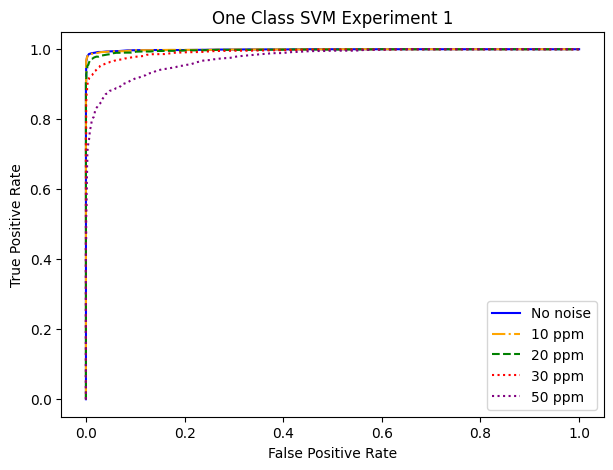

In [83]:
plt.plot(svm_exp1_CH4_fp[0],svm_exp1_CH4_tp[0],c='b',label='No noise')
plt.plot(svm_exp1_CH4_fp[1],svm_exp1_CH4_tp[1],c='orange',ls='-.',label='10 ppm')
plt.plot(svm_exp1_CH4_fp[2],svm_exp1_CH4_tp[2],c='g',ls='--',label='20 ppm')
plt.plot(svm_exp1_CH4_fp[3],svm_exp1_CH4_tp[3],c='r',ls='dotted',label='30 ppm')
plt.plot(svm_exp1_CH4_fp[4],svm_exp1_CH4_tp[4],c='purple',ls='dotted',label='50 ppm')
plt.title('One Class SVM Experiment 1')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

1CSVM for $NH_3$

In [84]:
NH3_tr = 13000
X_train = x_norm_dry_NH3[:NH3_tr]

svm = OneClassSVM(kernel='rbf',
                degree=3,
                gamma=0.2,
                coef0=0.0,
                tol=0.001,
                nu=0.01,
                shrinking=True,
                cache_size=200,
                verbose=False,
                max_iter=-1)

svm.fit(X_train)

# ideal NH3
X_test = x_norm_dry_NH3[NH3_tr:]
X_novelty = x_norm_wet_NH3[:X_test.shape[0],:]
scores_test_svm_ideal = svm.decision_function(X_test)
scores_novelty_svm_ideal = svm.decision_function(X_novelty)

# 10 ppm NH3
X_test = x_norm_dry_NH3_10ppm[NH3_tr:]
X_novelty = x_norm_wet_NH3_10ppm[:X_test.shape[0],:]
scores_test_svm_10ppm = svm.decision_function(X_test)
scores_novelty_svm_10ppm = svm.decision_function(X_novelty)

# 20 ppm NH3
X_test = x_norm_dry_NH3_20ppm[NH3_tr:]
X_novelty = x_norm_wet_NH3_20ppm[:X_test.shape[0],:]
scores_test_svm_20ppm = svm.decision_function(X_test)
scores_novelty_svm_20ppm = svm.decision_function(X_novelty)

# 30 ppm NH3
X_test = x_norm_dry_NH3_30ppm[NH3_tr:]
X_novelty = x_norm_wet_NH3_30ppm[:X_test.shape[0],:]
scores_test_svm_30ppm = svm.decision_function(X_test)
scores_novelty_svm_30ppm = svm.decision_function(X_novelty)

# 50 ppm NH3
X_test = x_norm_dry_NH3_50ppm[NH3_tr:]
X_novelty = x_norm_wet_NH3_50ppm[:X_test.shape[0],:]
scores_test_svm_50ppm = svm.decision_function(X_test)
scores_novelty_svm_50ppm = svm.decision_function(X_novelty)

Scatter plots of the true log concentration values vs. the 1CSVM scores at different noise levels. The normal points are colored black and the novel points are colored by their log relative concentrations.

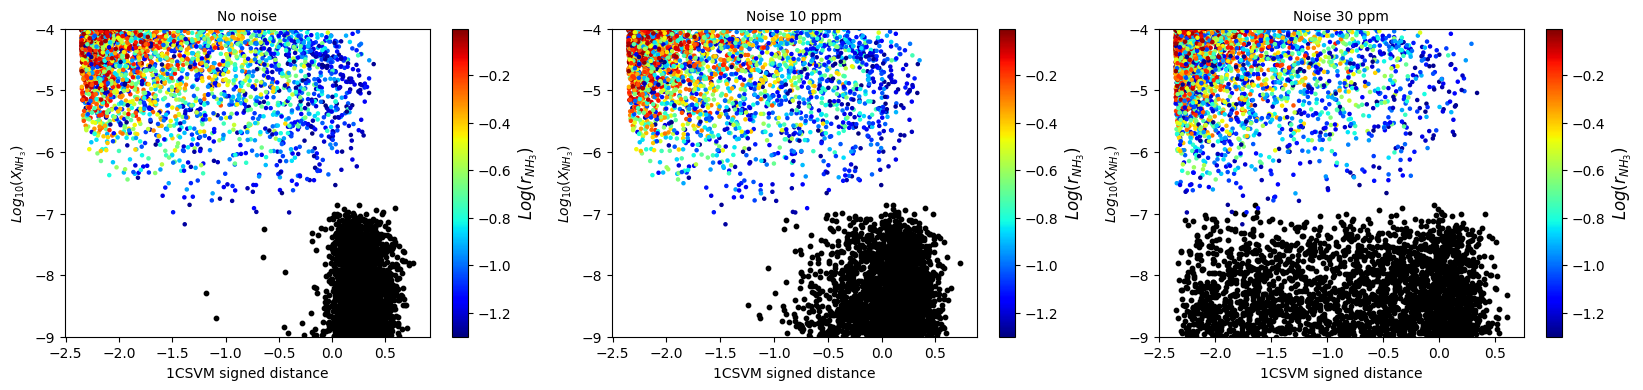

In [85]:
plt.subplots(1,3,figsize=(20,4))
plt.subplot(1,3,1)
plt.scatter( scores_test_svm_ideal,FM_dry_NH3[NH3_tr:,NH3_conc], c='black', s=10)
im = plt.scatter( scores_novelty_svm_ideal, FM_wet_NH3[:X_test.shape[0],NH3_conc], c=np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('1CSVM signed distance',fontsize=10)
plt.ylabel('$Log_{10}(X_{NH_3})$',fontsize=10)
plt.title('No noise',fontsize=10)
# plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{NH_3})$')
cb.set_label(label='$Log(r_{NH_3})$', size='large', weight='bold')

plt.subplot(1,3,2)
plt.scatter( scores_test_svm_10ppm,FM_dry_NH3[NH3_tr:,NH3_conc], c='black', s=10)
im = plt.scatter( scores_novelty_svm_10ppm, FM_wet_NH3[:X_test.shape[0],NH3_conc], c=np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('1CSVM signed distance',fontsize=10)
plt.ylabel('$Log_{10}(X_{NH_3})$',fontsize=10)
plt.title('Noise 10 ppm',fontsize=10)
# plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{NH_3})$')
cb.set_label(label='$Log(r_{NH_3})$', size='large', weight='bold')


plt.subplot(1,3,3)
plt.scatter( scores_test_svm_30ppm,FM_dry_NH3[NH3_tr:,NH3_conc], c='black', s=10)
im = plt.scatter( scores_novelty_svm_30ppm, FM_wet_NH3[:X_test.shape[0],NH3_conc], c=np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('1CSVM signed distance',fontsize=10)
plt.ylabel('$Log_{10}(X_{NH_3})$',fontsize=10)
plt.title('Noise 30 ppm',fontsize=10)
# plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{NH_3})$')
cb.set_label(label='$Log(r_{NH_3})$', size='large', weight='bold')
# plt.savefig('lof_novelty_scatter.png',bbox_inches='tight')

In [86]:
X_train = x_norm_dry_NH3[:NH3_tr]


test_list = [x_norm_dry_NH3,
             x_norm_dry_NH3_10ppm,
             x_norm_dry_NH3_20ppm,
             x_norm_dry_NH3_30ppm,
             x_norm_dry_NH3_50ppm]

train_list = [x_norm_wet_NH3,
              x_norm_wet_NH3_10ppm,
              x_norm_wet_NH3_20ppm,
              x_norm_wet_NH3_30ppm,
              x_norm_wet_NH3_50ppm]

n = 200
svm_exp1_NH3_fp = np.zeros((5,n))
svm_exp1_NH3_tp = np.zeros((5,n))
limits = np.linspace(start=-3,stop=1,num=n)

svm = OneClassSVM(kernel='rbf',
                degree=3,
                gamma=0.2,
                coef0=0.0,
                tol=0.001,
                nu=0.01,
                shrinking=True,
                cache_size=200,
                verbose=False,
                max_iter=-1)

svm.fit(X_train)


for item in range(5):
  X_test = test_list[item][NH3_tr:]
  X_novelty = train_list[item][:X_test.shape[0],:]
  scores_test_svm = svm.decision_function(X_test)
  scores_novelty_svm = svm.decision_function(X_novelty)
  for i in range(n):
    limit=limits[i]
    svm_exp1_NH3_fp[item,i] = (scores_test_svm<limit).sum()/X_test.shape[0]
    svm_exp1_NH3_tp[item,i] = (scores_novelty_svm<limit).sum()/X_novelty.shape[0]

ROC Curves for different 1CSVM training cases with different levels of noise.

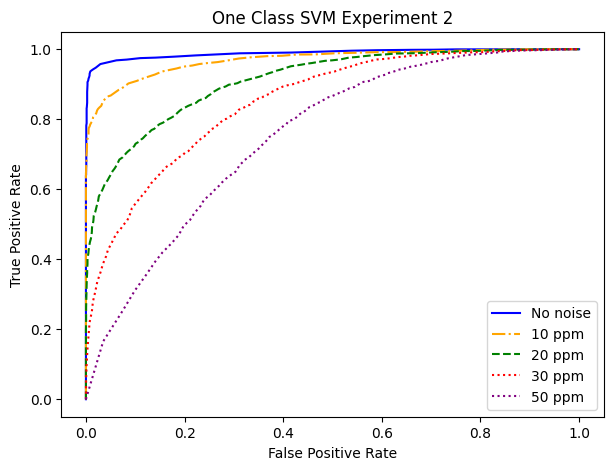

In [87]:
plt.plot(svm_exp1_NH3_fp[0],svm_exp1_NH3_tp[0],c='b',label='No noise')
plt.plot(svm_exp1_NH3_fp[1],svm_exp1_NH3_tp[1],c='orange',ls='-.',label='10 ppm')
plt.plot(svm_exp1_NH3_fp[2],svm_exp1_NH3_tp[2],c='g',ls='--',label='20 ppm')
plt.plot(svm_exp1_NH3_fp[3],svm_exp1_NH3_tp[3],c='r',ls='dotted',label='30 ppm')
plt.plot(svm_exp1_NH3_fp[4],svm_exp1_NH3_tp[4],c='purple',ls='dotted',label='50 ppm')
plt.title('One Class SVM Experiment 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

1CSVM for $H_2O$

In [88]:
H2O_tr_tr = 10000
X_train = x_norm_dry_H20[:H2O_tr]

svm = OneClassSVM(kernel='rbf',
                degree=3,
                gamma=0.2,
                coef0=0.0,
                tol=0.001,
                nu=0.01,
                shrinking=True,
                cache_size=200,
                verbose=False,
                max_iter=-1)

svm.fit(X_train)

# ideal NH3
X_test = x_norm_dry_H20[H2O_tr:]
X_novelty = x_norm_wet_H20[:X_test.shape[0],:]
scores_test_svm_ideal = svm.decision_function(X_test)
scores_novelty_svm_ideal = svm.decision_function(X_novelty)

# 10 ppm NH3
X_test = x_norm_dry_H20_10ppm[H2O_tr:]
X_novelty = x_norm_wet_H20_10ppm[:X_test.shape[0],:]
scores_test_svm_10ppm = svm.decision_function(X_test)
scores_novelty_svm_10ppm = svm.decision_function(X_novelty)

# 20 ppm NH3
X_test = x_norm_dry_H20_20ppm[H2O_tr:]
X_novelty = x_norm_wet_H20_20ppm[:X_test.shape[0],:]
scores_test_svm_20ppm = svm.decision_function(X_test)
scores_novelty_svm_20ppm = svm.decision_function(X_novelty)

# 30 ppm NH3
X_test = x_norm_dry_H20_30ppm[H2O_tr:]
X_novelty = x_norm_wet_H20_30ppm[:X_test.shape[0],:]
scores_test_svm_30ppm = svm.decision_function(X_test)
scores_novelty_svm_30ppm = svm.decision_function(X_novelty)

# 50 ppm NH3
X_test = x_norm_dry_H20_50ppm[H2O_tr:]
X_novelty = x_norm_wet_H20_50ppm[:X_test.shape[0],:]
scores_test_svm_50ppm = svm.decision_function(X_test)
scores_novelty_svm_50ppm = svm.decision_function(X_novelty)

Scatter plots of the true log concentration values vs. the 1CSVM scores at different noise levels. The normal points are colored black and the novel points are colored by their log relative concentrations.

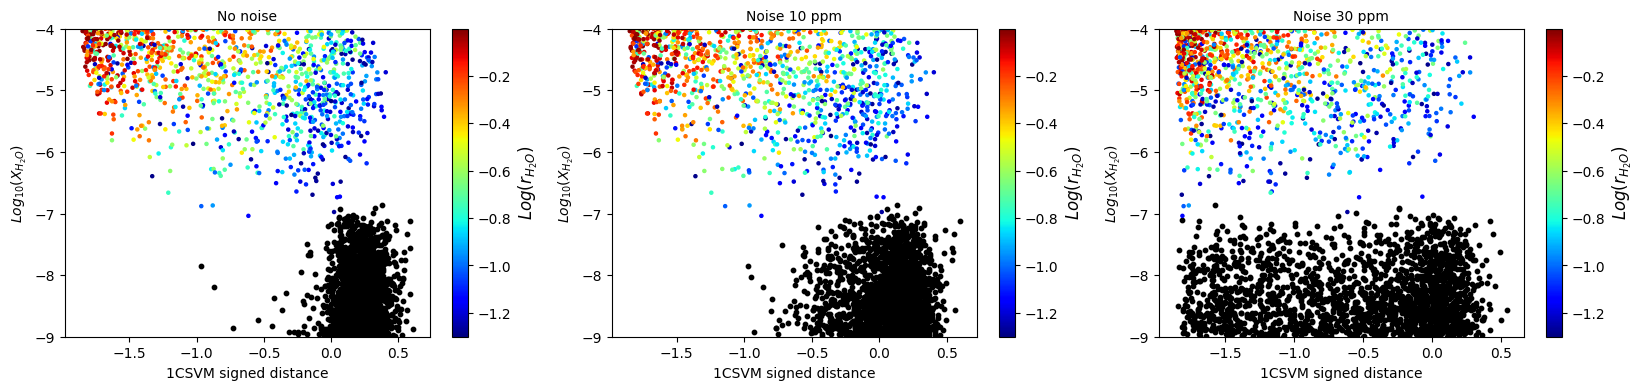

In [89]:
plt.subplots(1,3,figsize=(20,4))
plt.subplot(1,3,1)
plt.scatter( scores_test_svm_ideal,FM_dry_H20[H2O_tr:,H20_conc], c='black', s=10)
im = plt.scatter( scores_novelty_svm_ideal, FM_wet_H20[:X_test.shape[0],H20_conc], c=np.log10(conc_rel_wet_H20[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('1CSVM signed distance',fontsize=10)
plt.ylabel('$Log_{10}(X_{H_2O})$',fontsize=10)
plt.title('No noise',fontsize=10)
# plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{H_2O})$')
cb.set_label(label='$Log(r_{H_2O})$', size='large', weight='bold')

plt.subplot(1,3,2)
plt.scatter( scores_test_svm_10ppm,FM_dry_H20[H2O_tr:,H20_conc], c='black', s=10)
im = plt.scatter( scores_novelty_svm_10ppm, FM_wet_H20[:X_test.shape[0],H20_conc], c=np.log10(conc_rel_wet_H20[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('1CSVM signed distance',fontsize=10)
plt.ylabel('$Log_{10}(X_{H_2O})$',fontsize=10)
plt.title('Noise 10 ppm',fontsize=10)
# plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{H_2O})$')
cb.set_label(label='$Log(r_{H_2O})$', size='large', weight='bold')


plt.subplot(1,3,3)
plt.scatter( scores_test_svm_30ppm,FM_dry_H20[H2O_tr:,H20_conc], c='black', s=10)
im = plt.scatter( scores_novelty_svm_30ppm, FM_wet_H20[:X_test.shape[0],H20_conc], c=np.log10(conc_rel_wet_H20[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('1CSVM signed distance',fontsize=10)
plt.ylabel('$Log_{10}(X_{H_2O})$',fontsize=10)
plt.title('Noise 30 ppm',fontsize=10)
# plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{H_2O})$')
cb.set_label(label='$Log(r_{H_2O})$', size='large', weight='bold')
# plt.savefig('lof_novelty_scatter.png',bbox_inches='tight')

In [90]:
X_train = x_norm_dry_H20[:H2O_tr]


test_list = [x_norm_dry_H20,
             x_norm_dry_H20_10ppm,
             x_norm_dry_H20_20ppm,
             x_norm_dry_H20_30ppm,
             x_norm_dry_H20_50ppm]

train_list = [x_norm_wet_H20,
              x_norm_wet_H20_10ppm,
              x_norm_wet_H20_20ppm,
              x_norm_wet_H20_30ppm,
              x_norm_wet_H20_50ppm]

n = 200
svm_exp1_H20_fp = np.zeros((5,n))
svm_exp1_H20_tp = np.zeros((5,n))
limits = np.linspace(start=-3,stop=1,num=n)

svm = OneClassSVM(kernel='rbf',
                degree=3,
                gamma=0.2,
                coef0=0.0,
                tol=0.001,
                nu=0.01,
                shrinking=True,
                cache_size=200,
                verbose=False,
                max_iter=-1)

svm.fit(X_train)


for item in range(5):
  X_test = test_list[item][H2O_tr:]
  X_novelty = train_list[item][:X_test.shape[0],:]
  scores_test_svm = svm.decision_function(X_test)
  scores_novelty_svm = svm.decision_function(X_novelty)
  for i in range(n):
    limit=limits[i]
    svm_exp1_H20_fp[item,i] = (scores_test_svm<limit).sum()/X_test.shape[0]
    svm_exp1_H20_tp[item,i] = (scores_novelty_svm<limit).sum()/X_novelty.shape[0]

ROC Curves for different 1CSVM training cases with different levels of noise.

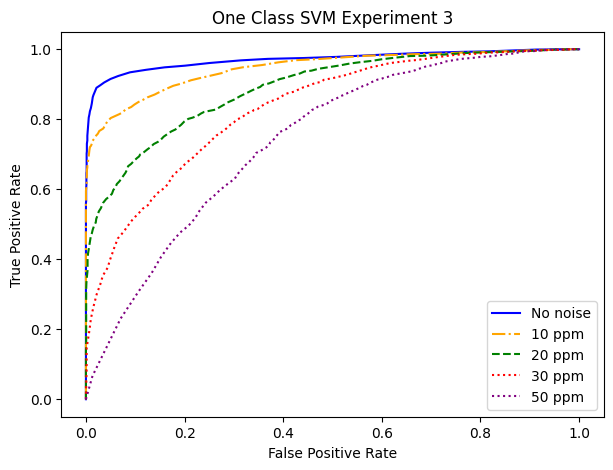

In [91]:
plt.plot(svm_exp1_H20_fp[0],svm_exp1_H20_tp[0],c='b',label='No noise')
plt.plot(svm_exp1_H20_fp[1],svm_exp1_H20_tp[1],c='orange',ls='-.',label='10 ppm')
plt.plot(svm_exp1_H20_fp[2],svm_exp1_H20_tp[2],c='g',ls='--',label='20 ppm')
plt.plot(svm_exp1_H20_fp[3],svm_exp1_H20_tp[3],c='r',ls='dotted',label='30 ppm')
plt.plot(svm_exp1_H20_fp[4],svm_exp1_H20_tp[4],c='purple',ls='dotted',label='50 ppm')
plt.title('One Class SVM Experiment 3')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

1CSVM for $CO_2$

In [92]:
CO2_tr = 13000
X_train = x_norm_dry_CO2[:CO2_tr]

svm = OneClassSVM(kernel='rbf',
                degree=3,
                gamma=0.2,
                coef0=0.0,
                tol=0.001,
                nu=0.01,
                shrinking=True,
                cache_size=200,
                verbose=False,
                max_iter=-1)

svm.fit(X_train)

# ideal CO2
X_test = x_norm_dry_CO2[CO2_tr:]
X_novelty = x_norm_wet_CO2[:X_test.shape[0],:]
scores_test_svm_ideal = svm.decision_function(X_test)
scores_novelty_svm_ideal = svm.decision_function(X_novelty)

# 10 ppm CO2
X_test = x_norm_dry_CO2_10ppm[CO2_tr:]
X_novelty = x_norm_wet_CO2_10ppm[:X_test.shape[0],:]
scores_test_svm_10ppm = svm.decision_function(X_test)
scores_novelty_svm_10ppm = svm.decision_function(X_novelty)

# 20 ppm CO2
X_test = x_norm_dry_CO2_20ppm[CO2_tr:]
X_novelty = x_norm_wet_CO2_20ppm[:X_test.shape[0],:]
scores_test_svm_20ppm = svm.decision_function(X_test)
scores_novelty_svm_20ppm = svm.decision_function(X_novelty)

# 30 ppm CO2
X_test = x_norm_dry_CO2_30ppm[CO2_tr:]
X_novelty = x_norm_wet_CO2_30ppm[:X_test.shape[0],:]
scores_test_svm_30ppm = svm.decision_function(X_test)
scores_novelty_svm_30ppm = svm.decision_function(X_novelty)

# 50 ppm CO2
X_test = x_norm_dry_CO2_50ppm[CO2_tr:]
X_novelty = x_norm_wet_CO2_50ppm[:X_test.shape[0],:]
scores_test_svm_50ppm = svm.decision_function(X_test)
scores_novelty_svm_50ppm = svm.decision_function(X_novelty)

Histograms of scores for normal and anomalous samples at different noise levels

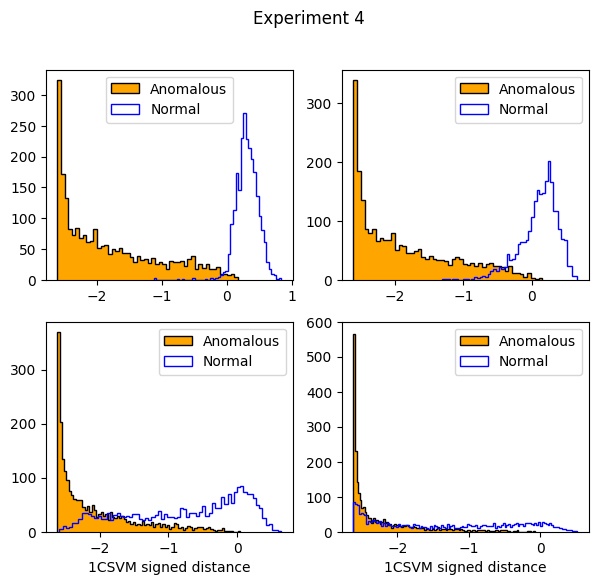

In [93]:
plt.subplots(2,2,figsize=(7,6))
plt.subplot(2,2,1)
plt.hist(scores_novelty_svm_ideal,bins=50,color='orange',edgecolor='black',histtype='step',facecolor='orange',fill=True,label='Anomalous')
plt.hist(scores_test_svm_ideal,bins=50,edgecolor='b', histtype='step', facecolor='g',label='Normal')#fill=False,hatch=None)
# plt.xlim(0,8)
plt.legend()

plt.subplot(2,2,2)
plt.hist(scores_novelty_svm_10ppm,bins=50,color='orange',edgecolor='black',histtype='step',facecolor='orange',fill=True,label='Anomalous')
plt.hist(scores_test_svm_10ppm,bins=50,edgecolor='b', histtype='step', facecolor='g',label='Normal')#fill=False,hatch=None)
# plt.xlim(0,8)
plt.legend()

plt.subplot(2,2,3)
plt.hist(scores_novelty_svm_30ppm,bins=80,color='orange',edgecolor='black',histtype='step',facecolor='orange',fill=True,label='Anomalous')
plt.hist(scores_test_svm_30ppm,bins=70,edgecolor='b', histtype='step', facecolor='g',label='Normal')#fill=False,hatch=None)
# plt.xlim(0,8)
plt.xlabel('1CSVM signed distance')
plt.legend()

plt.subplot(2,2,4)
plt.hist(scores_novelty_svm_50ppm,bins=110,color='orange',edgecolor='black',histtype='step',facecolor='orange',fill=True,label='Anomalous')
plt.hist(scores_test_svm_50ppm,bins=120,edgecolor='b', histtype='step', facecolor='g',label='Normal')#fill=False,hatch=None)
plt.ylim(0,600)
plt.legend()
plt.suptitle('Experiment 4')
# plt.xlim(0,8)
plt.xlabel('1CSVM signed distance')
plt.show()

Scatter plots of the true log concentration values vs. the 1CSVM scores at different noise levels. The normal points are colored black and the novel points are colored by their log relative concentrations.

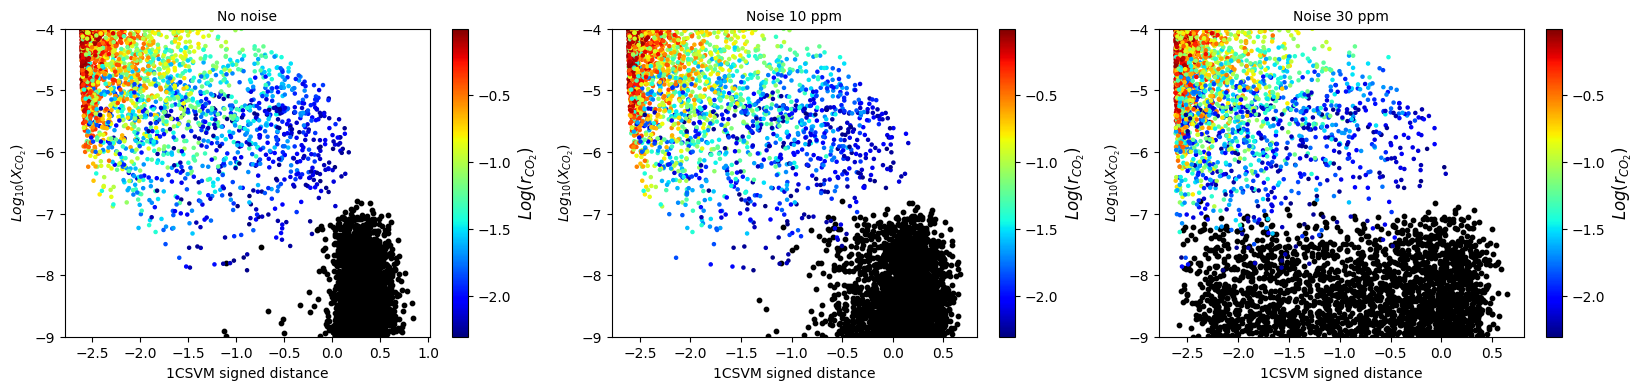

In [94]:
plt.subplots(1,3,figsize=(20,4))
plt.subplot(1,3,1)
plt.scatter( scores_test_svm_ideal,FM_dry_CO2[CO2_tr:,CO2_conc], c='black', s=10)
im = plt.scatter( scores_novelty_svm_ideal, FM_wet_CO2[:X_test.shape[0],CO2_conc], c=np.log10(conc_rel_wet_CO2[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('1CSVM signed distance',fontsize=10)
plt.ylabel('$Log_{10}(X_{CO_2})$',fontsize=10)
plt.title('No noise',fontsize=10)
# plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{CO_2})$')
cb.set_label(label='$Log(r_{CO_2})$', size='large', weight='bold')

plt.subplot(1,3,2)
plt.scatter( scores_test_svm_10ppm,FM_dry_CO2[CO2_tr:,CO2_conc], c='black', s=10)
im = plt.scatter( scores_novelty_svm_10ppm, FM_wet_CO2[:X_test.shape[0],CO2_conc], c=np.log10(conc_rel_wet_CO2[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('1CSVM signed distance',fontsize=10)
plt.ylabel('$Log_{10}(X_{CO_2})$',fontsize=10)
plt.title('Noise 10 ppm',fontsize=10)
# plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{CO_2})$')
cb.set_label(label='$Log(r_{CO_2})$', size='large', weight='bold')


plt.subplot(1,3,3)
plt.scatter( scores_test_svm_30ppm,FM_dry_CO2[CO2_tr:,CO2_conc], c='black', s=10)
im = plt.scatter( scores_novelty_svm_30ppm, FM_wet_CO2[:X_test.shape[0],CO2_conc], c=np.log10(conc_rel_wet_CO2[:X_test.shape[0]]), s=5, cmap='jet')
plt.xlabel('1CSVM signed distance',fontsize=10)
plt.ylabel('$Log_{10}(X_{CO_2})$',fontsize=10)
plt.title('Noise 30 ppm',fontsize=10)
# plt.xlim(0,20)
plt.ylim(-9,-4)
# plt.yscale('log')
cb = plt.colorbar(im,label='$Log(r_{CO_2})$')
cb.set_label(label='$Log(r_{CO_2})$', size='large', weight='bold')
# plt.savefig('lof_novelty_scatter.png',bbox_inches='tight')

In [95]:
X_train = x_norm_dry_CO2[:CO2_tr]


test_list = [x_norm_dry_CO2,
             x_norm_dry_CO2_10ppm,
             x_norm_dry_CO2_20ppm,
             x_norm_dry_CO2_30ppm,
             x_norm_dry_CO2_50ppm]

train_list = [x_norm_wet_CO2,
              x_norm_wet_CO2_10ppm,
              x_norm_wet_CO2_20ppm,
              x_norm_wet_CO2_30ppm,
              x_norm_wet_CO2_50ppm]

n = 200
svm_exp1_CO2_fp = np.zeros((5,n))
svm_exp1_CO2_tp = np.zeros((5,n))
limits = np.linspace(start=-3,stop=1,num=n)

svm = OneClassSVM(kernel='rbf',
                degree=3,
                gamma=0.2,
                coef0=0.0,
                tol=0.001,
                nu=0.01,
                shrinking=True,
                cache_size=200,
                verbose=False,
                max_iter=-1)

svm.fit(X_train)


for item in range(5):
  X_test = test_list[item][CO2_tr:]
  X_novelty = train_list[item][:X_test.shape[0],:]
  scores_test_svm = svm.decision_function(X_test)
  scores_novelty_svm = svm.decision_function(X_novelty)
  for i in range(n):
    limit=limits[i]
    svm_exp1_CO2_fp[item,i] = (scores_test_svm<limit).sum()/X_test.shape[0]
    svm_exp1_CO2_tp[item,i] = (scores_novelty_svm<limit).sum()/X_novelty.shape[0]

ROC Curves for different 1CSVM training cases with different levels of noise.

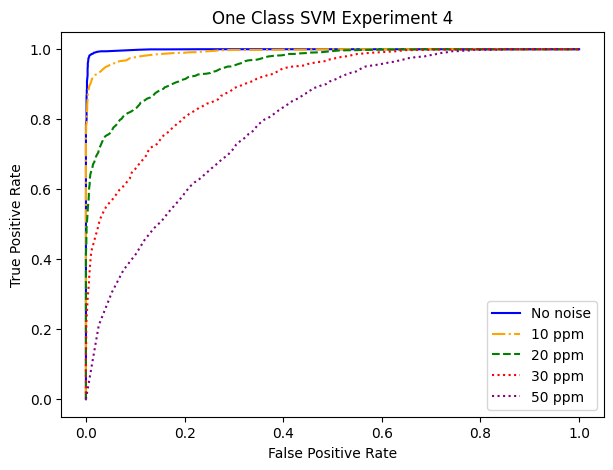

In [96]:
plt.plot(svm_exp1_CO2_fp[0],svm_exp1_CO2_tp[0],c='b',label='No noise')
plt.plot(svm_exp1_CO2_fp[1],svm_exp1_CO2_tp[1],c='orange',ls='-.',label='10 ppm')
plt.plot(svm_exp1_CO2_fp[2],svm_exp1_CO2_tp[2],c='g',ls='--',label='20 ppm')
plt.plot(svm_exp1_CO2_fp[3],svm_exp1_CO2_tp[3],c='r',ls='dotted',label='30 ppm')
plt.plot(svm_exp1_CO2_fp[4],svm_exp1_CO2_tp[4],c='purple',ls='dotted',label='50 ppm')
plt.title('One Class SVM Experiment 4')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [97]:
NH3_tr = 13000
X_train = x_norm_dry_NH3[:NH3_tr]

# ideal NH3
X_test = x_norm_dry_NH3[NH3_tr:]
X_novelty = x_norm_wet_NH3[:X_test.shape[0],:]

In [98]:
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

svm_sgd = make_pipeline(
            Nystroem(gamma=0.25,degree=3,random_state=0, n_components=500,kernel='rbf'),
            SGDOneClassSVM( nu=0.02,
                            shuffle=True,
                            fit_intercept=True,
                            random_state=0,
                            tol=1e-4))
svm_sgd.fit(X_train)

Pipeline(steps=[('nystroem',
                 Nystroem(degree=3, gamma=0.25, n_components=500,
                          random_state=0)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(nu=0.02, random_state=0, tol=0.0001))])

In [99]:
result_train_svm_sgd = svm_sgd.predict(X_train)
result_test_svm_sgd = svm_sgd.predict(X_test)
result_novelty_svm_sgd = svm_sgd.predict(X_novelty)
result_moist_svm_sgd = svm_sgd.predict(x_norm_moi_NH3)
scores_test_svm_sgd = svm_sgd.score_samples(X_test)
scores_novelty_svm_sgd = svm_sgd.score_samples(X_novelty)
scores_moist_svm_sgd = svm_sgd.score_samples(x_norm_moi_NH3)

In [100]:
accuracy_svm = 1.0-np.sum(-scores_novelty_svm_sgd<-0.013)/X_novelty.shape[0]
print('Novelty Accuracy: ',accuracy_svm)

Novelty Accuracy:  0.876456053653371


In [101]:
error_svm = np.sum(-scores_test_svm_sgd>-0.013)/X_test.shape[0]
print('Novelty Error: ',error_svm)

Novelty Error:  0.012707377338510413


1CSVM histogram

Text(0.5, 0, 'SVM Score')

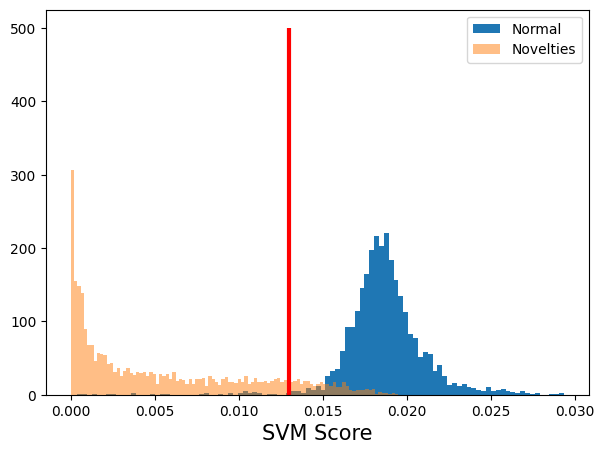

In [102]:
plt.hist(scores_test_svm_sgd, bins=100, label='Normal')
plt.hist(scores_novelty_svm_sgd, bins=100, alpha=0.5, label='Novelties')
plt.vlines(0.013, 0, 500, colors='r',lw=3)
plt.legend(loc='best')
# plt.yscale('log')
plt.xlabel('SVM Score', fontsize=15)

1CSVM scatter plot

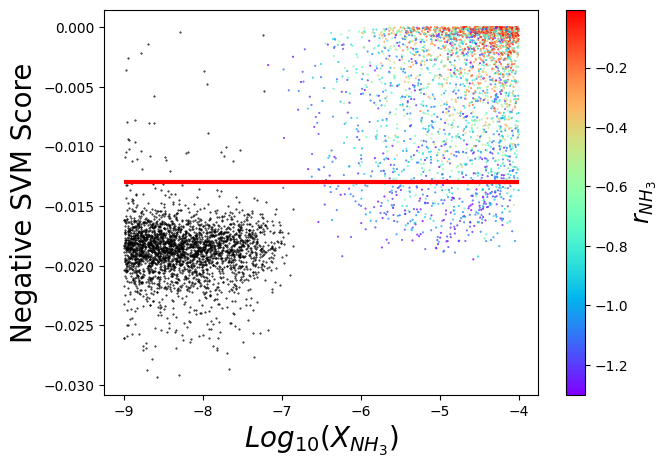

In [103]:
plt.scatter(FM_dry_NH3[NH3_tr:,5], -scores_test_svm_sgd, c='black', s=0.2)
im = plt.scatter(FM_wet_NH3[:X_test.shape[0],5], -scores_novelty_svm_sgd, c=np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), s=0.2, cmap='rainbow')

plt.xlabel('$Log_{10}(X_{NH_3})$', fontsize=20)
plt.ylabel('Negative SVM Score', fontsize=20)
plt.hlines(-0.013,-9,-4,color='r',lw=3)
# plt.yscale('log')
cb = plt.colorbar(im,label='$r_{NH_3}$')
cb.set_label(label='$r_{NH_3}$', size='xx-large', weight='bold')
# plt.savefig()

Negative 1CSVM score vs relative concentrations colored by normal, middle, and wet samples.

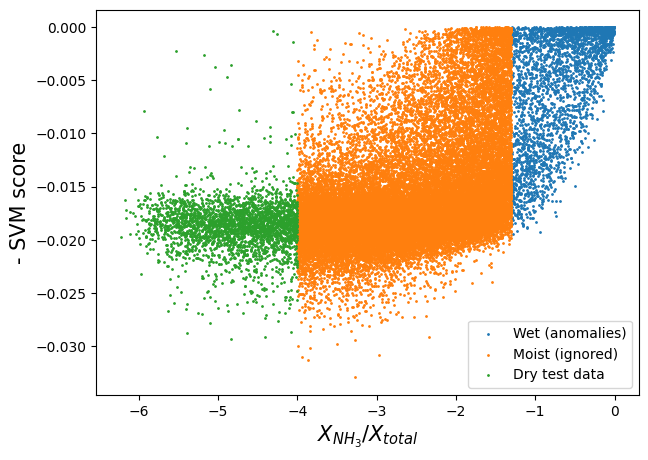

In [104]:
plt.scatter(np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), -scores_novelty_svm_sgd, s=1, label='Wet (anomalies)')
plt.scatter(np.log10(conc_rel_moi_NH3[:]), -scores_moist_svm_sgd, s=1, label='Moist (ignored)')
plt.scatter(np.log10(conc_rel_dry_NH3[NH3_tr:]), -scores_test_svm_sgd, s=1, label='Dry test data')
plt.xlabel('$X_{NH_3}/X_{total}$', fontsize=15)
plt.ylabel('- SVM score', fontsize=15)
# plt.xlim(1e-7,5)
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

### Method 3 of 3: Kernel Density Estimation (KDE)

Not used in publication.

In [105]:
NH3_tr = 13000
X_train = x_norm_dry_NH3[:NH3_tr]

# ideal NH3
X_test = x_norm_dry_NH3[NH3_tr:]
X_novelty = x_norm_wet_NH3[:X_test.shape[0],:]

In [106]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth=0.4,
                   algorithm='auto',
                   kernel='gaussian',
                   metric='euclidean',
                   atol=0, rtol=0,
                   leaf_size=100)
kde.fit(X_train)

KernelDensity(bandwidth=0.4, leaf_size=100)

In [107]:
# result_train_kde = kde.predict(X_train)
# result_test_kd = kd.predict(X_test)
# result_novelty_kd = kd.predict(X_novelty)
# result_moist_kd = kd.predict(x_norm_moi_NH3)
scores_test_kde = kde.score_samples(X_test)
scores_novelty_kde = kde.score_samples(X_novelty)
scores_moist_kde = kde.score_samples(x_norm_moi_NH3)

In [108]:
np.max(-scores_test_kde)

22.972385899809566

In [109]:
accuracy_kde = 1.0-np.sum(-scores_novelty_kde<np.max(-scores_test_kde))/X_novelty.shape[0]
print('Novelty Accuracy: ',accuracy_kde)

Novelty Accuracy:  0.6381927285563007


KDE histogram

Text(0.5, 0, 'KDE Score')

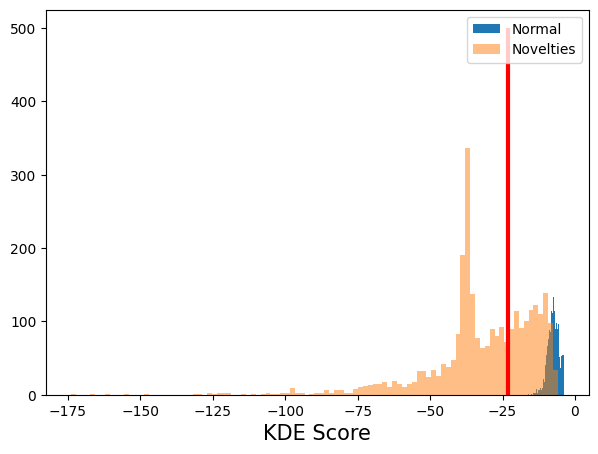

In [110]:
plt.hist(scores_test_kde, bins=100, label='Normal')
plt.hist(scores_novelty_kde, bins=100, alpha=0.5, label='Novelties')
plt.vlines(-np.max(-scores_test_kde), 0, 500, colors='r',lw=3)
plt.legend(loc='best')
# plt.yscale('log')
plt.xlabel('KDE Score', fontsize=15)

KDE scatter plot

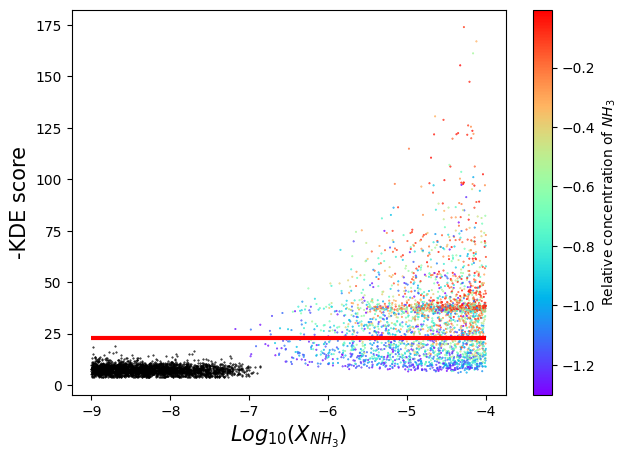

In [111]:
plt.scatter(FM_dry_NH3[NH3_tr:,5], -scores_test_kde, c='black', s=0.2)
plt.scatter(FM_wet_NH3[:X_test.shape[0],5], -scores_novelty_kde, c=np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), s=0.2, cmap='rainbow')

plt.xlabel('$Log_{10}(X_{NH_3})$', fontsize=15)
plt.ylabel('-KDE score', fontsize=15)
plt.hlines(np.max(-scores_test_kde),-9,-4,color='r',lw=3)
# plt.ylim([-70,10])
# plt.yscale('log')
plt.colorbar(label='Relative concentration of $NH_3$')

Negative KDE score vs relative concentrations colored by normal, middle, and wet samples.

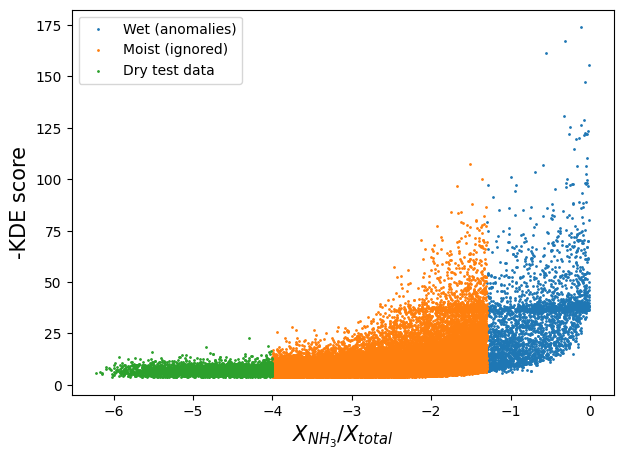

In [112]:
plt.scatter(np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), -scores_novelty_kde, s=1, label='Wet (anomalies)')
plt.scatter(np.log10(conc_rel_moi_NH3[:]), -scores_moist_kde, s=1, label='Moist (ignored)')
plt.scatter(np.log10(conc_rel_dry_NH3[NH3_tr:]), -scores_test_kde, s=1, label='Dry test data')
plt.xlabel('$X_{NH_3}/X_{total}$', fontsize=15)
plt.ylabel('-KDE score', fontsize=15)
# plt.xlim(1e-7,5)
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

Comparing novelty detection methods

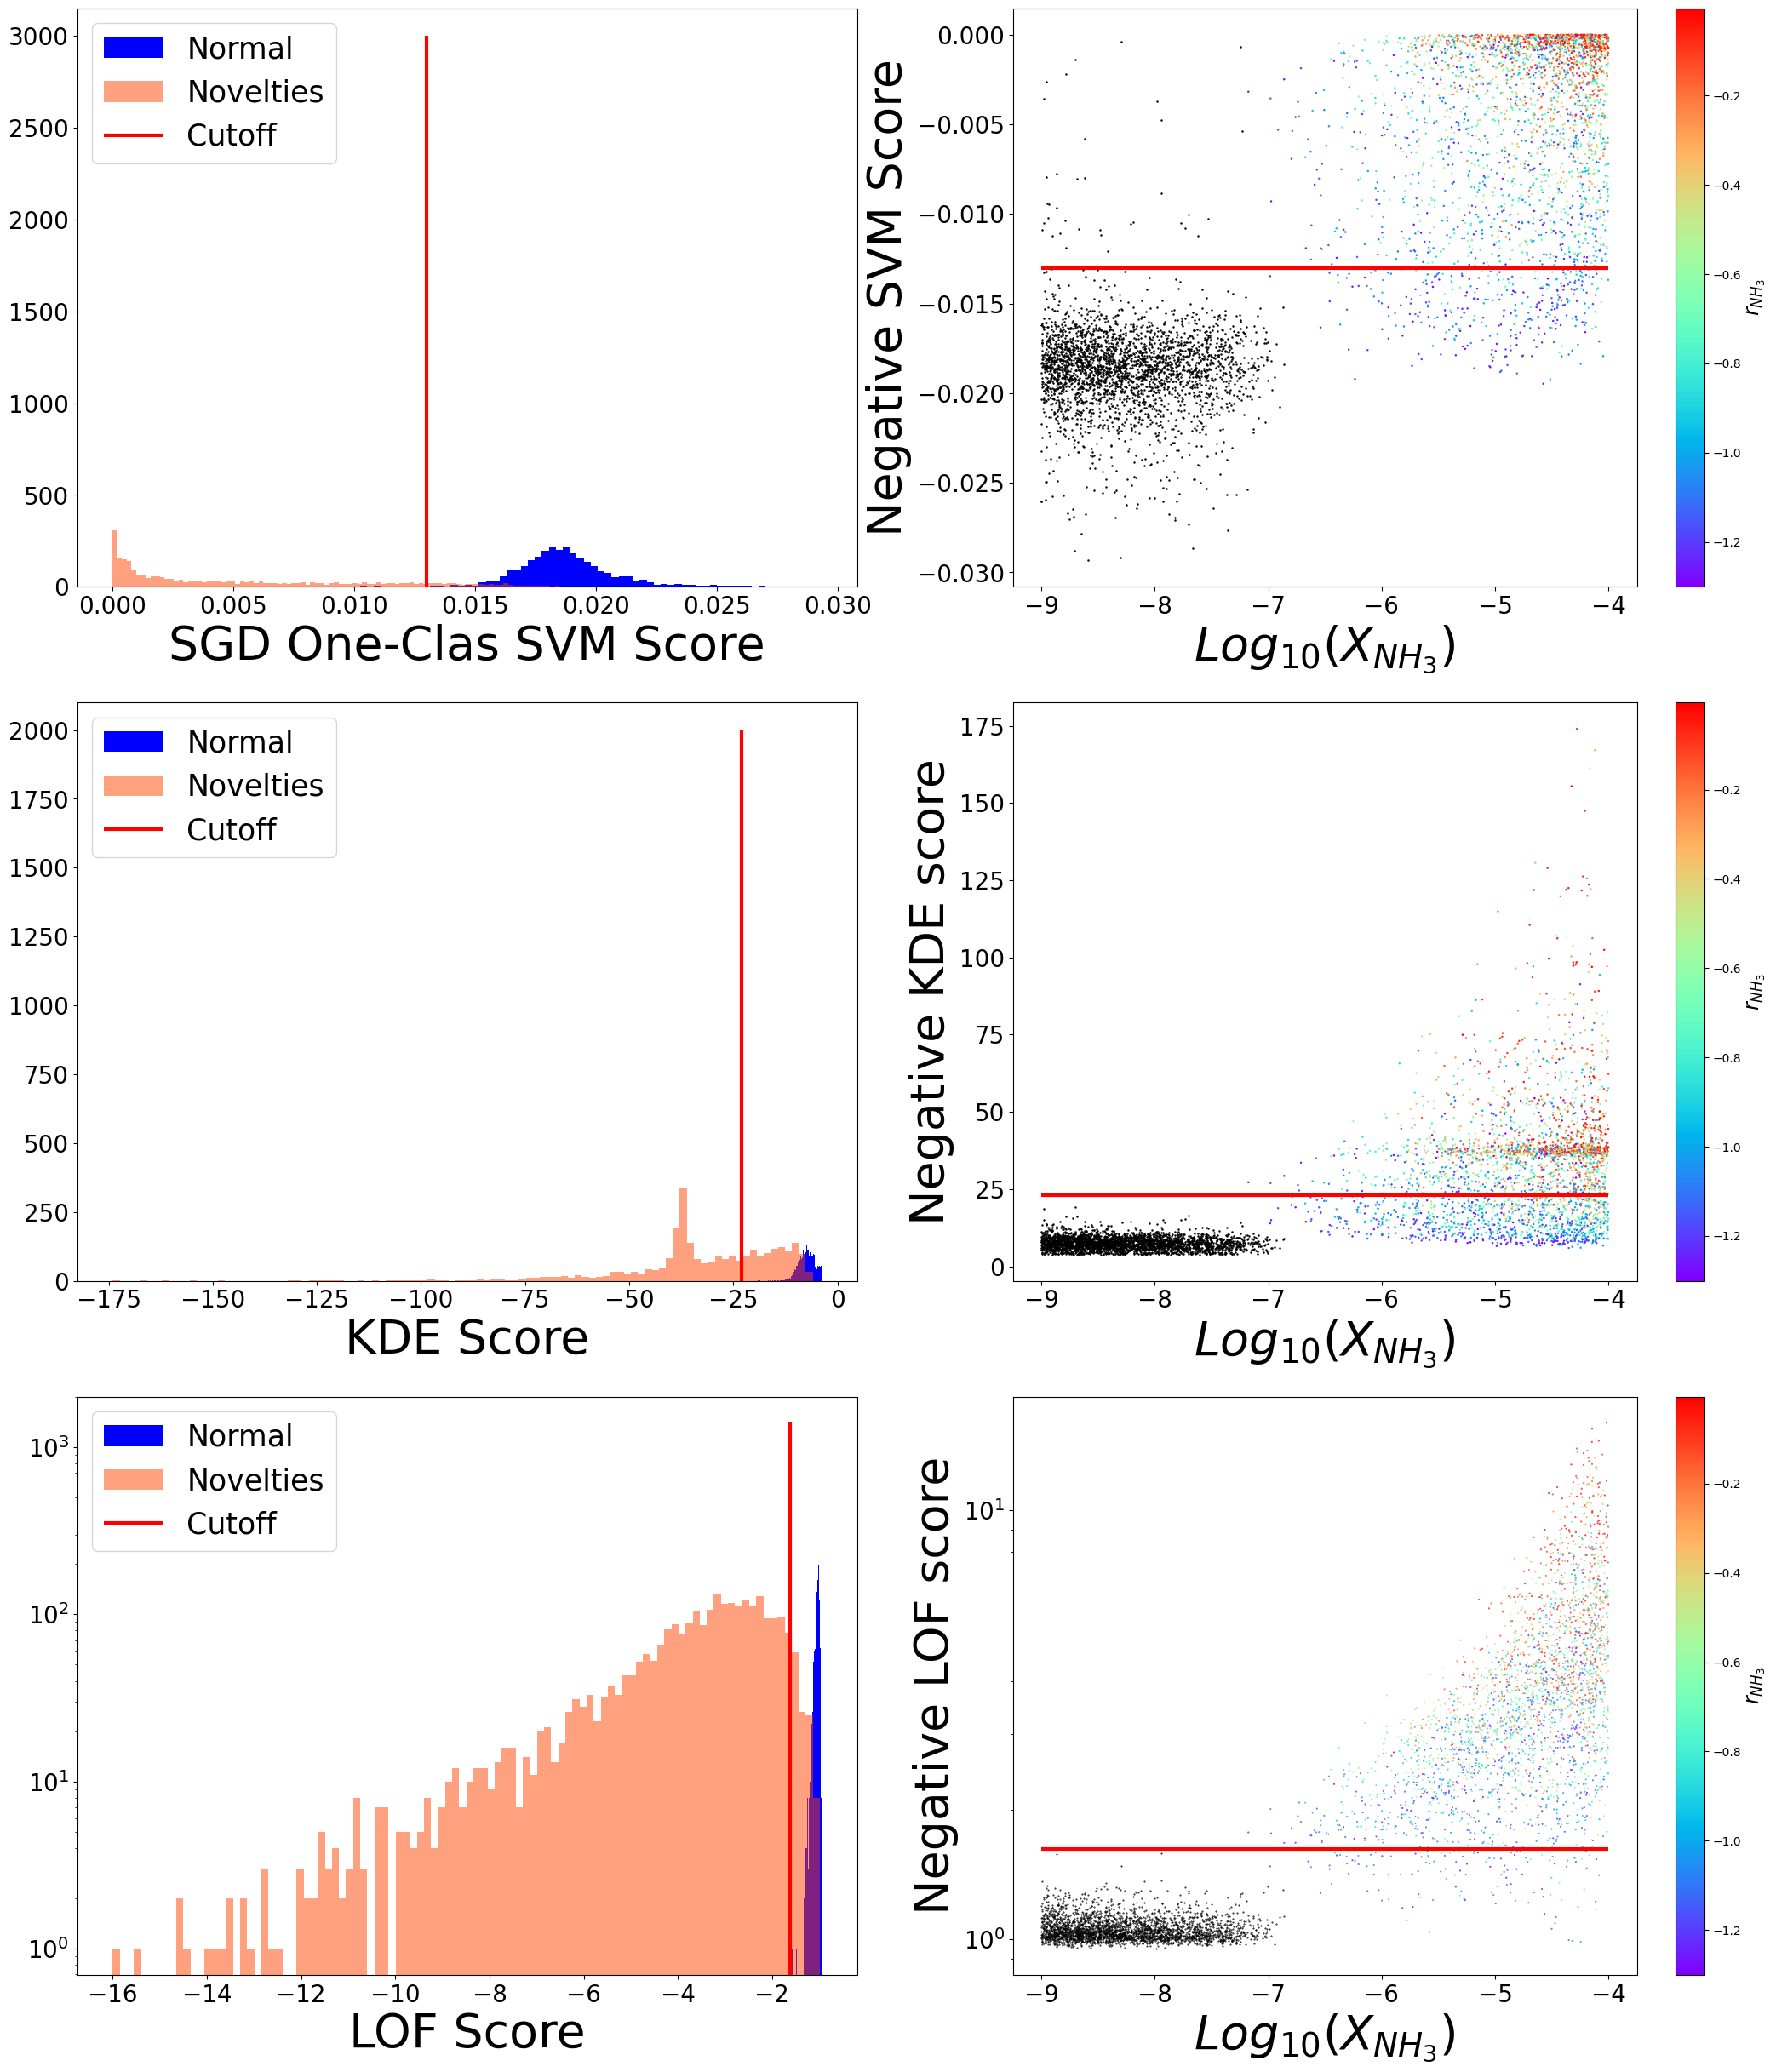

In [113]:
fig = plt.subplots(3,2,figsize=(26,30))
plt.subplot(3,2,1)
plt.hist(scores_test_svm_sgd, bins=100, color='b',label='Normal')
plt.hist(scores_novelty_svm_sgd, bins=100, color='orangered',alpha=0.5, label='Novelties')
plt.vlines(0.013, 0, 3000, colors='r',lw=3,label='Cutoff')
plt.legend(loc='upper left',fontsize = 25)
# plt.yscale('log')
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('SGD One-Clas SVM Score', fontsize=40)
# plt.savefig('svm_novelty_distr.png',bbox_inches = 'tight')
plt.subplot(3,2,2)
plt.scatter(FM_dry_NH3[NH3_tr:,5], -scores_test_svm_sgd, c='black', s=0.6)
im = plt.scatter(FM_wet_NH3[:X_test.shape[0],5], -scores_novelty_svm_sgd, c=np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), s=0.6, cmap='rainbow')
plt.xlabel('$Log_{10}(X_{NH_3})$', fontsize=40)
plt.ylabel('Negative SVM Score', fontsize=40)
plt.hlines(-0.013,-9,-4,color='r',lw=3,label='Cutoff')
plt.xticks(size=20)
plt.yticks(size=20)
# plt.yscale('log')
cb = plt.colorbar(im,label='$r_{NH_3}$')
cb.set_label(label='$r_{NH_3}$', size='xx-large', weight='bold')
# plt.savefig('svm_novelty_scatter.png',bbox_inches='tight')

plt.subplot(3,2,3)
plt.hist(scores_test_kde, bins=100, color='b',label='Normal')
plt.hist(scores_novelty_kde, bins=100, color='orangered',alpha=0.5, label='Novelties')
plt.vlines(-np.max(-scores_test_kde), 0, 2000, colors='r',lw=3,label='Cutoff')
plt.legend(loc='upper left',fontsize = 25)
# plt.yscale('log')
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('KDE Score', fontsize=40)
# plt.savefig('lof_novelty_distr.png',bbox_inches = 'tight')
plt.subplot(3,2,4)
plt.scatter(FM_dry_NH3[NH3_tr:,5], -scores_test_kde, c='black', s=0.6)
im = plt.scatter(FM_wet_NH3[:X_test.shape[0],5], -scores_novelty_kde, c=np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), s=0.6, cmap='rainbow')
plt.xlabel('$Log_{10}(X_{NH_3})$', fontsize=40)
plt.ylabel('Negative KDE score', fontsize=40)
plt.hlines(np.max(-scores_test_kde),-9,-4,color='r',lw=3,label='Cutoff')
plt.xticks(size=20)
plt.yticks(size=20)
# plt.yscale('log')
cb = plt.colorbar(im,label='$r_{NH_3}$')
cb.set_label(label='$r_{NH_3}$', size='xx-large', weight='bold')
# plt.savefig('lof_novelty_scatter.png',bbox_inches='tight')


plt.subplot(3,2,5)
plt.hist(scores_test_lof, bins=100, color='b',label='Normal')
plt.hist(scores_novelty_lof, bins=100, color='orangered',alpha=0.5, label='Novelties')
plt.vlines(-np.max(-scores_test_lof), 0, 1400, colors='r',lw=3,label='Cutoff')
plt.legend(loc='upper left',fontsize = 25)
plt.yscale('log')
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('LOF Score', fontsize=40)
# plt.savefig('lof_novelty_distr.png',bbox_inches = 'tight')
plt.subplot(3,2,6)
plt.scatter(FM_dry_NH3[NH3_tr:,5], -scores_test_lof, c='black', s=0.2)
im = plt.scatter(FM_wet_NH3[:X_test.shape[0],5], -scores_novelty_lof, c=np.log10(conc_rel_wet_NH3[:X_test.shape[0]]), s=0.2, cmap='rainbow')
plt.xlabel('$Log_{10}(X_{NH_3})$', fontsize=40)
plt.ylabel('Negative LOF score', fontsize=40)
plt.hlines(np.max(-scores_test_lof),-9,-4,color='r',lw=3,label='Cutoff')
plt.xticks(size=20)
plt.yticks(size=20)
plt.yscale('log')
cb = plt.colorbar(im,label='$r_{NH_3}$')
cb.set_label(label='$r_{NH_3}$', size='xx-large', weight='bold')
plt.savefig('novelty_all.png',bbox_inches='tight')


# Outlier Detection Methods

Not presented in paper.

Traiing outlier detection methods on a mixture of dry $90\%$ and wet $10\%$. Then, testing on incoming test data of both dry and wet planets, which were not used in the training.


Hoped to use:
$$ 0.1 = \frac{x}{15000+x} \implies x = 1667$$

Ended up using $x=250$:
$$\frac{250}{15000+250} = 0.01639$$

Infiltration of the training set of $1.639 \%$ was found to be sufficient.

In [114]:
# N_outlier = 1000
# y_norm_dry_NH3 = np.ones((x_norm_dry_NH3[:15000].shape[0],1))-1
# y_norm_wet_NH3 = np.ones((N_outlier,1))
# X_train_with_labels = np.vstack([ np.concatenate([x_norm_dry_NH3[:15000],y_norm_dry_NH3 ],axis=1),
#                                      np.concatenate([x_norm_wet_NH3[:N_outlier],y_norm_wet_NH3 ],axis=1)  ])
# X_train_with_labels.shape

In [115]:
# X_train_with_labels[:,52]

In [116]:
# np.random.seed(0)
# np.random.shuffle(X_train_with_labels)
# X_train_outlier_with_labels = X_train_with_labels[:,:52]

In [117]:
# labels = 1-X_train_with_labels[:,52]
# labels[labels==0] =-1
# labels = labels.astype(int)

In [118]:
N_outlier = 250
X_train_outlier = np.vstack([ x_norm_dry_NH3[:15000],
                              x_norm_wet_NH3[:N_outlier] ])
np.random.seed(0)
np.random.shuffle(X_train_outlier)
X_test_outlier = x_norm_dry_NH3[15000:]
X_novelty_outlier = x_norm_wet_NH3[N_outlier:]

In [119]:
X_train_outlier.shape

(15250, 52)

In [120]:
X_test_outlier.shape

(833, 52)

In [121]:
X_novelty_outlier.shape

(16038, 52)

### Method 1 of 3: One-Class SVM with RBF Kernel  (1CSVM)

In [122]:
svm_sgd = make_pipeline(
            Nystroem(gamma = 0.25, random_state=0, n_components=500,kernel='rbf'),
            SGDOneClassSVM( nu=0.05,
                            shuffle=True,
                            fit_intercept=True,
                            random_state=0,
                            tol=1e-4,
                            max_iter=1000))
svm_sgd.fit(X_train_outlier)

Pipeline(steps=[('nystroem',
                 Nystroem(gamma=0.25, n_components=500, random_state=0)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(nu=0.05, random_state=0, tol=0.0001))])

In [123]:
result_train_svm_sgd_outlier = svm_sgd.predict(X_train_outlier)
result_test_svm_sgd_outlier = svm_sgd.predict(X_test_outlier)
result_novelty_svm_sgd_outlier = svm_sgd.predict(X_novelty_outlier)
result_moist_svm_sgd_outlier = svm_sgd.predict(x_norm_moi_NH3)
scores_test_svm_sgd_outlier = svm_sgd.score_samples(X_test_outlier)
scores_novelty_svm_sgd_outlier = svm_sgd.score_samples(X_novelty_outlier)
scores_moist_svm_sgd_outlier = svm_sgd.score_samples(x_norm_moi_NH3)

In [124]:
# Test accuracy
np.where(result_test_svm_sgd_outlier==1)[0].shape[0]/X_test_outlier.shape[0]

0.9651860744297719

In [125]:
# Outlier Accuracy
np.where(result_novelty_svm_sgd_outlier==-1)[0].shape[0]/X_novelty_outlier.shape[0]

0.5109739368998628

In [126]:
accuracy_svm_outlier = 1.0-np.sum(-scores_novelty_svm_sgd_outlier<-0.013)/X_novelty_outlier.shape[0]
print('Novelty Accuracy: ',accuracy_svm_outlier)

Novelty Accuracy:  0.3114478114478114


In [127]:
error_svm_outlier = np.sum(-scores_test_svm_sgd_outlier>-0.013)/X_test_outlier.shape[0]
print('Novelty Error: ',error_svm_outlier)

Novelty Error:  0.015606242496998799


1CSVM hisogram

Text(0.5, 0, 'SGD One-Clas SVM Score')

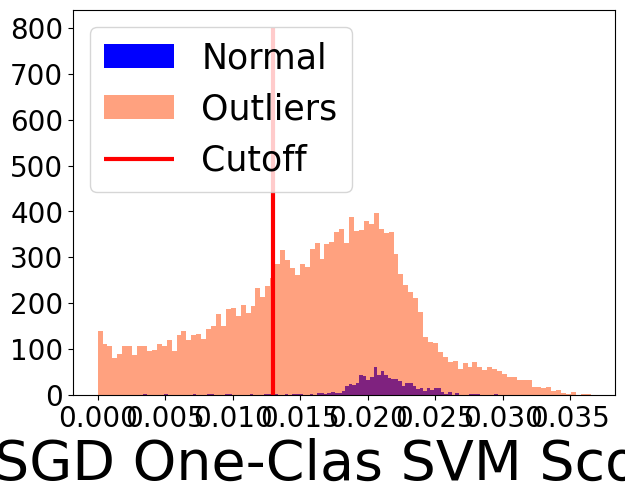

In [128]:
plt.hist(scores_test_svm_sgd_outlier, bins=100, color='b',label='Normal')
plt.hist(scores_novelty_svm_sgd_outlier, bins=100, color='orangered',alpha=0.5, label='Outliers')
plt.vlines(0.013, 0, 800, colors='r',lw=3,label='Cutoff')
plt.legend(loc='upper left',fontsize = 25)
# plt.yscale('log')
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('SGD One-Clas SVM Score', fontsize=40)
# plt.savefig('svm_novelty_distr.png',bbox_inches = 'tight')

1CSVM scatter

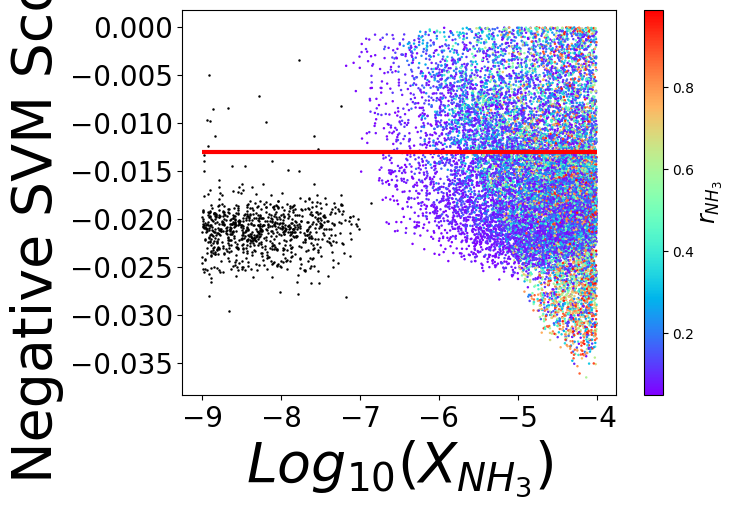

In [129]:
plt.scatter(FM_dry_NH3[15000:,5], -scores_test_svm_sgd_outlier, c='black', s=0.6)
im = plt.scatter(FM_wet_NH3[N_outlier:,5], -scores_novelty_svm_sgd_outlier, c=conc_rel_wet_NH3[N_outlier:], s=0.6, cmap='rainbow')
plt.xlabel('$Log_{10}(X_{NH_3})$', fontsize=40)
plt.ylabel('Negative SVM Score', fontsize=40)
plt.hlines(-0.013,-9,-4,color='r',lw=3,label='Cutoff')
plt.xticks(size=20)
plt.yticks(size=20)
# plt.yscale('log')
cb = plt.colorbar(im,label='$r_{NH_3}$')
cb.set_label(label='$r_{NH_3}$', size='xx-large', weight='bold')

### Method 2 of 3: Kernel Density Estimation (KDE)

In [130]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth=0.7,
                   algorithm='auto',
                   kernel='gaussian',
                   metric='euclidean',
                   atol=0, rtol=0,
                   leaf_size=100)

kde.fit(X_train_outlier)

KernelDensity(bandwidth=0.7, leaf_size=100)

In [131]:
# result_train_kde_outlier = kde.predict(X_train_outlier)
# result_test_kde_outlier = kde.predict(X_test_outlier)
# result_novelty_kde_outlier = kde.predict(X_novelty_outlier)
# result_moist_kde_outlier = kde.predict(x_norm_moi_NH3)
scores_test_kde_outlier = kde.score_samples(X_test_outlier)
scores_novelty_kde_outlier = kde.score_samples(X_novelty_outlier)
scores_moist_kde_outlier = kde.score_samples(x_norm_moi_NH3)

In [132]:
# # Test accuracy
# np.where(result_test_kde_outlier==1)[0].shape[0]/X_test_outlier.shape[0]

In [133]:
# # Outlier Accuracy
# np.where(result_novelty_kde_outlier==-1)[0].shape[0]/X_novelty_outlier.shape[0]

In [134]:
accuracy_kde_outlier = 1.0-np.sum(scores_novelty_kde_outlier>-37)/X_novelty_outlier.shape[0]
print('Novelty Accuracy: ',accuracy_kde_outlier)

Novelty Accuracy:  0.7564534231200898


In [135]:
error_kde_outlier = np.sum(scores_test_kde_outlier<-37)/X_test_outlier.shape[0]
print('Novelty Error: ',error_kde_outlier)

Novelty Error:  0.060024009603841535


KDE histogram

Text(0.5, 0, 'KDE Score')

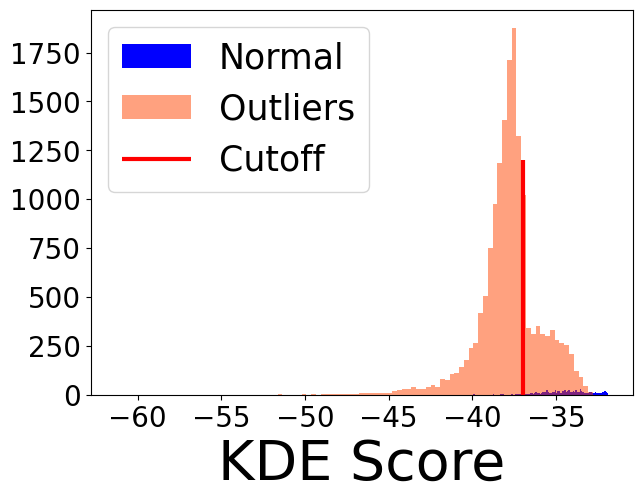

In [136]:
plt.hist(scores_test_kde_outlier, bins=100, color='b',label='Normal')
plt.hist(scores_novelty_kde_outlier, bins=100, color='orangered',alpha=0.5, label='Outliers')
plt.vlines(-37, 0, 1200, colors='r',lw=3,label='Cutoff')
plt.legend(loc='upper left',fontsize = 25)
# plt.yscale('log')
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('KDE Score', fontsize=40)
# plt.savefig('svm_novelty_distr.png',bbox_inches = 'tight')

KDE scatter

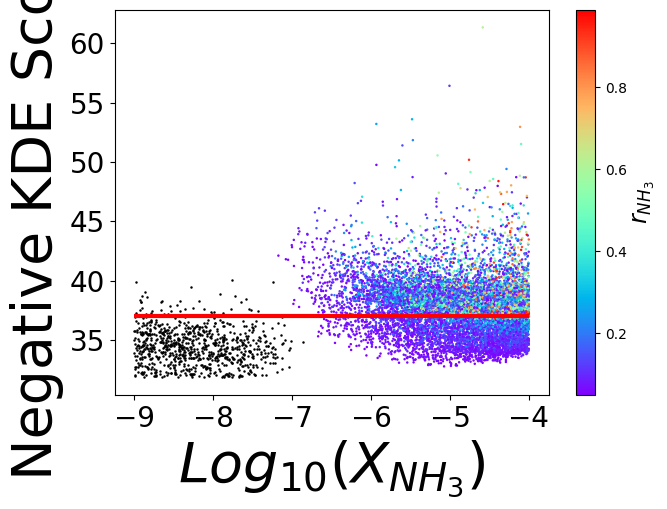

In [137]:
plt.scatter(FM_dry_NH3[15000:,5], -scores_test_kde_outlier, c='black', s=0.6)
im = plt.scatter(FM_wet_NH3[N_outlier:,5], -scores_novelty_kde_outlier, c=conc_rel_wet_NH3[N_outlier:], s=0.6, cmap='rainbow')
plt.xlabel('$Log_{10}(X_{NH_3})$', fontsize=40)
plt.ylabel('Negative KDE Score', fontsize=40)
plt.hlines(37,-9,-4,color='r',lw=3,label='Cutoff')
plt.xticks(size=20)
plt.yticks(size=20)
# plt.yscale('log')
cb = plt.colorbar(im,label='$r_{NH_3}$')
cb.set_label(label='$r_{NH_3}$', size='xx-large', weight='bold')

### Method 3 of 3: Local Outlier Factor (LOF)

In [138]:
lof = LocalOutlierFactor(n_neighbors=300, novelty=True)
lof.fit(X_train_outlier)
# lof.fit_predict(X_train_outlier)
# lof_scores = lof.negative_outlier_factor_

LocalOutlierFactor(n_neighbors=300, novelty=True)

In [139]:
# np.min(lof_scores)

In [140]:
# min_ids = np.zeros(shape=(X_test_outlier.shape[0],25),dtype='int32')
# scores_test_lof_outlier = np.zeros(shape=(X_test_outlier.shape[0],),dtype='float32')
# for idx,normal_test_sample in enumerate(X_test_outlier):
#   min_ids[idx] = np.argsort( np.sum((normal_test_sample-X_train_outlier)**2,axis=1) )[:25]
#   scores_test_lof_outlier[idx] = np.mean(lof_scores[min_ids[idx]])

In [141]:
# min_ids = np.zeros(shape=(X_novelty_outlier.shape[0],25),dtype='int32')
# scores_novelty_lof_outlier = np.zeros(shape=(X_novelty_outlier.shape[0],),dtype='float32')
# for idx,outlier_test_sample in enumerate(X_novelty_outlier):
#   min_ids[idx] = np.argsort( np.sum((outlier_test_sample-X_train_outlier)**2,axis=1) )[:25]
#   scores_novelty_lof_outlier[idx] = np.mean(lof_scores[min_ids[idx]])

In [142]:
# result_test_lof_outlier = lof.predict(X_test_outlier)
# result_novelty_lof_outlier = lof.predict(X_novelty_outlier)
# result_moist_lof_outlier = lof.predict(x_norm_moi_NH3)
scores_test_lof_outlier = lof.score_samples(X_test_outlier)
scores_novelty_lof_outlier = lof.score_samples(X_novelty_outlier)
scores_moist_lof_outlier = lof.score_samples(x_norm_moi_NH3)

In [143]:
# # Test accuracy
# np.where(result_test_lof_outlier==1)[0].shape[0]/X_test_outlier.shape[0]

In [144]:
# # Outlier Accuracy
# np.where(result_novelty_lof_outlier==-1)[0].shape[0]/X_novelty_outlier.shape[0]

In [145]:
accuracy_lof_outlier = 1.0-np.sum(scores_novelty_lof_outlier>-1.2)/X_novelty_outlier.shape[0]
print('Novelty Accuracy: ',accuracy_lof_outlier)

Novelty Accuracy:  0.9075321112358149


In [146]:
error_lof_outlier = np.sum(scores_test_lof_outlier<-1.2)/X_test_outlier.shape[0]
print('Novelty Error: ',error_lof_outlier)

Novelty Error:  0.07202881152460984


LOF histogram

Text(0.5, 0, 'LOF Score')

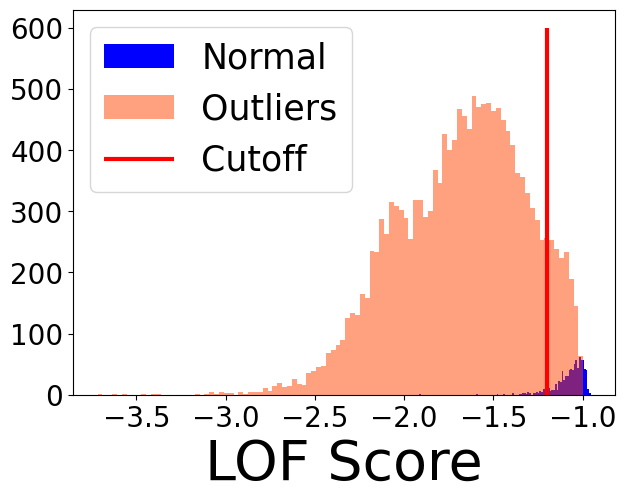

In [147]:
plt.hist(scores_test_lof_outlier, bins=100, color='b',label='Normal')
plt.hist(scores_novelty_lof_outlier, bins=100, color='orangered',alpha=0.5, label='Outliers')
plt.vlines(-1.2, 0, 600, colors='r',lw=3,label='Cutoff')
plt.legend(loc='upper left',fontsize = 25)
# plt.yscale('log')
# plt.xlim(-3.1,-0.95)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('LOF Score', fontsize=40)
# plt.savefig('svm_novelty_distr.png',bbox_inches = 'tight')

LOF scatter

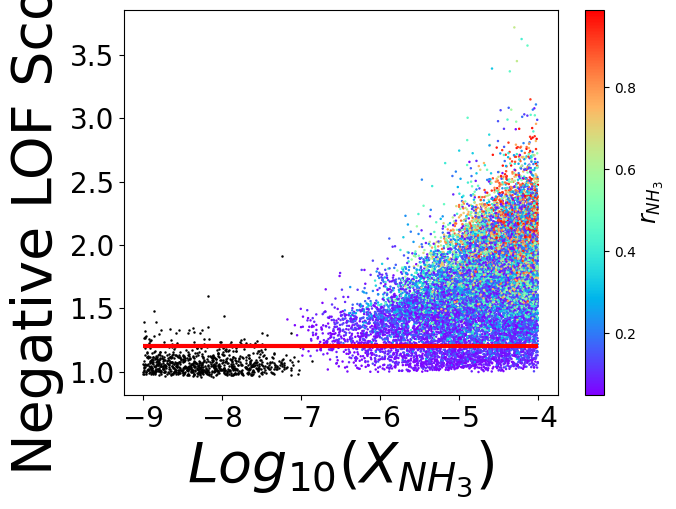

In [148]:
plt.scatter(FM_dry_NH3[15000:,5], -scores_test_lof_outlier, c='black', s=0.6)
im = plt.scatter(FM_wet_NH3[N_outlier:,5], -scores_novelty_lof_outlier, c=conc_rel_wet_NH3[N_outlier:], s=0.6, cmap='rainbow')
plt.xlabel('$Log_{10}(X_{NH_3})$', fontsize=40)
plt.ylabel('Negative LOF Score', fontsize=40)
plt.hlines(1.2,-9,-4,color='r',lw=3,label='Cutoff')
plt.xticks(size=20)
plt.yticks(size=20)
# plt.yscale('log')
cb = plt.colorbar(im,label='$r_{NH_3}$')
cb.set_label(label='$r_{NH_3}$', size='xx-large', weight='bold')

Comparing outlier detection methods

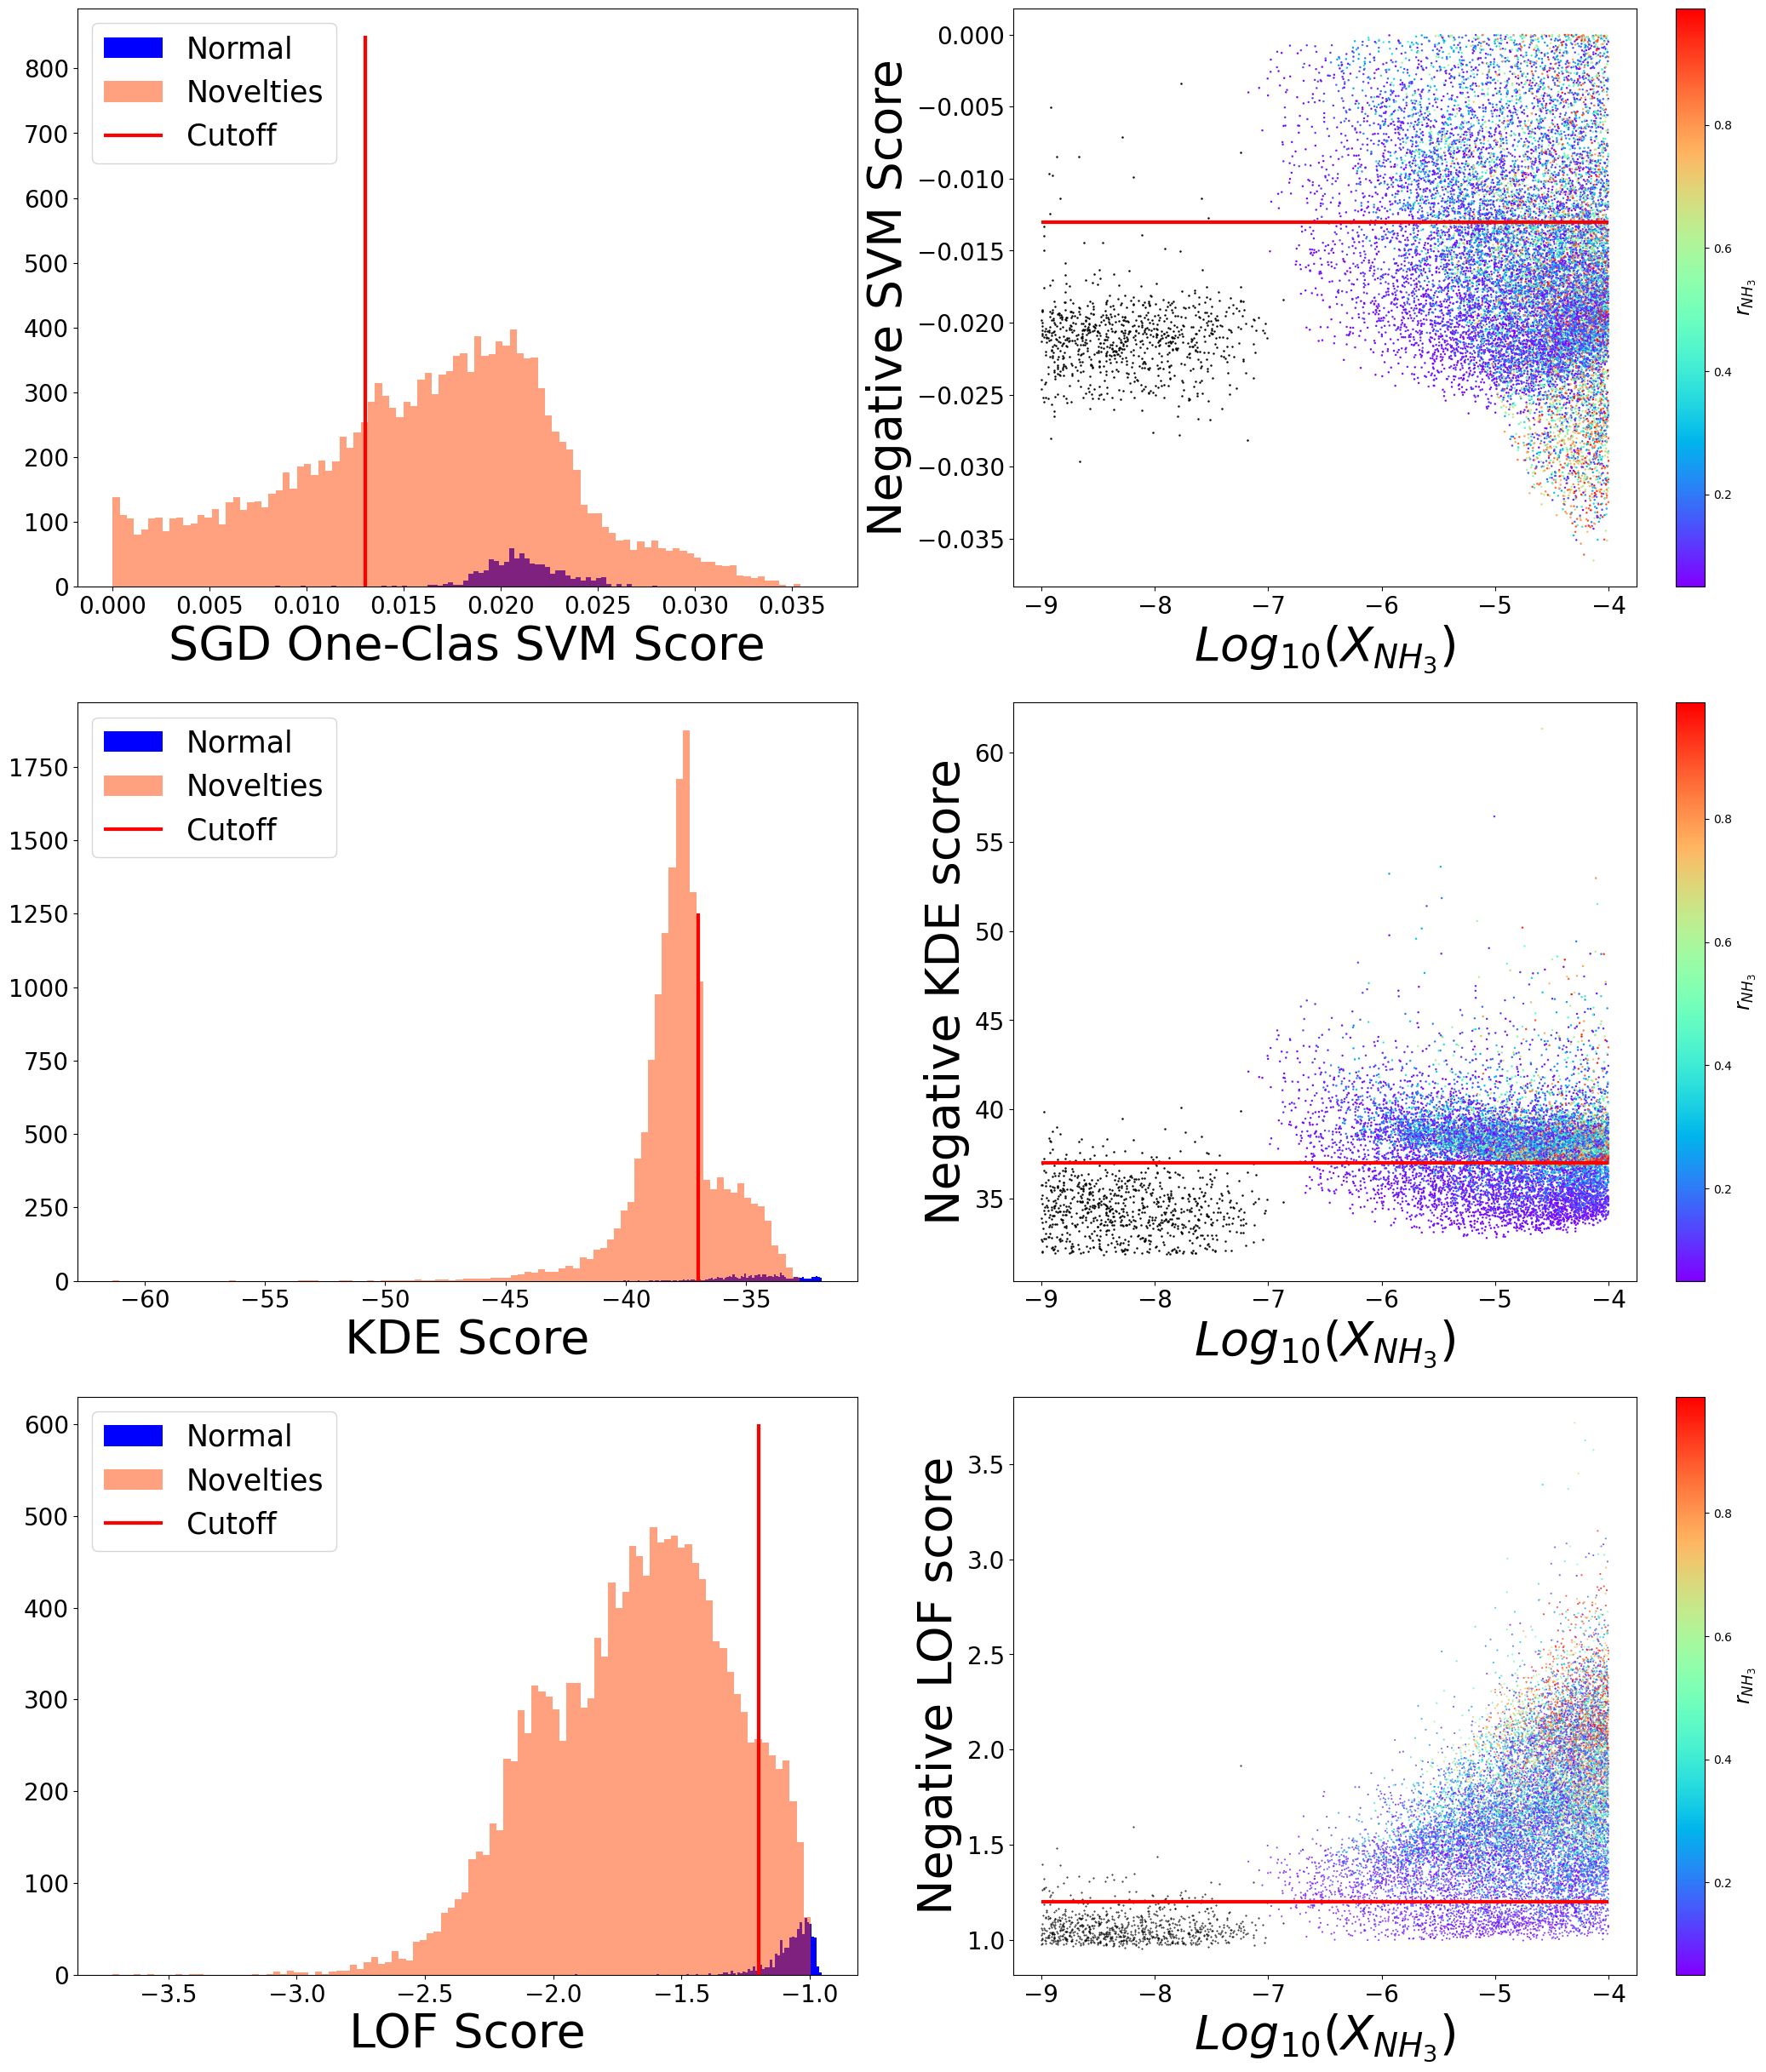

In [149]:
fig = plt.subplots(3,2,figsize=(26,30))
plt.subplot(3,2,1)
plt.hist(scores_test_svm_sgd_outlier, bins=100, color='b',label='Normal')
plt.hist(scores_novelty_svm_sgd_outlier, bins=100, color='orangered',alpha=0.5, label='Novelties')
plt.vlines(0.013, 0, 850, colors='r',lw=3,label='Cutoff')
plt.legend(loc='upper left',fontsize = 25)
# plt.yscale('log')
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('SGD One-Clas SVM Score', fontsize=40)
# plt.savefig('svm_novelty_distr.png',bbox_inches = 'tight')
plt.subplot(3,2,2)
plt.scatter(FM_dry_NH3[15000:,5], -scores_test_svm_sgd_outlier, c='black', s=0.6)
im = plt.scatter(FM_wet_NH3[N_outlier:,5], -scores_novelty_svm_sgd_outlier, c=conc_rel_wet_NH3[N_outlier:], s=0.6, cmap='rainbow')
plt.xlabel('$Log_{10}(X_{NH_3})$', fontsize=40)
plt.ylabel('Negative SVM Score', fontsize=40)
plt.hlines(-0.013,-9,-4,color='r',lw=3,label='Cutoff')
plt.xticks(size=20)
plt.yticks(size=20)
# plt.yscale('log')
cb = plt.colorbar(im,label='$r_{NH_3}$')
cb.set_label(label='$r_{NH_3}$', size='xx-large', weight='bold')
# plt.savefig('svm_novelty_scatter.png',bbox_inches='tight')

plt.subplot(3,2,3)
plt.hist(scores_test_kde_outlier, bins=100, color='b',label='Normal')
plt.hist(scores_novelty_kde_outlier, bins=100, color='orangered',alpha=0.5, label='Novelties')
plt.vlines(-37, 0, 1250, colors='r',lw=3,label='Cutoff')
plt.legend(loc='upper left',fontsize = 25)
# plt.yscale('log')
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('KDE Score', fontsize=40)
# plt.savefig('lof_novelty_distr.png',bbox_inches = 'tight')
plt.subplot(3,2,4)
plt.scatter(FM_dry_NH3[15000:,5], -scores_test_kde_outlier, c='black', s=0.6)
im = plt.scatter(FM_wet_NH3[N_outlier:,5], -scores_novelty_kde_outlier, c=conc_rel_wet_NH3[N_outlier:], s=0.6, cmap='rainbow')
plt.xlabel('$Log_{10}(X_{NH_3})$', fontsize=40)
plt.ylabel('Negative KDE score', fontsize=40)
plt.hlines(37,-9,-4,color='r',lw=3,label='Cutoff')
plt.xticks(size=20)
plt.yticks(size=20)
# plt.yscale('log')
cb = plt.colorbar(im,label='$r_{NH_3}$')
cb.set_label(label='$r_{NH_3}$', size='xx-large', weight='bold')
# plt.savefig('lof_novelty_scatter.png',bbox_inches='tight')


plt.subplot(3,2,5)
plt.hist(scores_test_lof_outlier, bins=100, color='b',label='Normal')
plt.hist(scores_novelty_lof_outlier, bins=100, color='orangered',alpha=0.5, label='Novelties')
plt.vlines(-1.2, 0, 600, colors='r',lw=3,label='Cutoff')
plt.legend(loc='upper left',fontsize = 25)
# plt.yscale('log')
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('LOF Score', fontsize=40)
# plt.savefig('lof_novelty_distr.png',bbox_inches = 'tight')
plt.subplot(3,2,6)
plt.scatter(FM_dry_NH3[15000:,5], -scores_test_lof_outlier, c='black', s=0.2)
im = plt.scatter(FM_wet_NH3[N_outlier:,5], -scores_novelty_lof_outlier, c=conc_rel_wet_NH3[N_outlier:], s=0.2, cmap='rainbow')
plt.xlabel('$Log_{10}(X_{NH_3})$', fontsize=40)
plt.ylabel('Negative LOF score', fontsize=40)
plt.hlines(1.2,-9,-4,color='r',lw=3,label='Cutoff')
plt.xticks(size=20)
plt.yticks(size=20)
# plt.yscale('log')
cb = plt.colorbar(im,label='$r_{NH_3}$')
cb.set_label(label='$r_{NH_3}$', size='xx-large', weight='bold')
plt.savefig('outlier_all.png',bbox_inches='tight')
